# DRIVE SAFE IN GENEVA


# 1. Load dataset

First of all, some useful libraries will be imported and the dataset will be loaded. Then the dataset shape and the data type of each feature will be inspectioned:

In [1]:
# Import used libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import folium

from pyproj import Proj, transform

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse

import pickle
import pylab

In [2]:
# Load dataset
acc_data = '_data/OTC_ACCIDENTS.csv'
#compt_trafic_data = '../_data/OTC_COMPTAGE_TRAFIC.csv'
acc_df = pd.read_csv(acc_data, sep=';', encoding='latin-1')
#compt_trafic_df = pd.read_csv(compt_trafic_data, sep=';', encoding='latin-1')

# Show the dataset
acc_df.head(3)

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,...,NB_MOTOS_50,NB_MOTOS_125,NB_MOTOS_11KW,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,E,N
0,876245.0,2010-11-30 00:00:00,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,2500774.0,1117364.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2500774.0,1117364.0
1,879408.0,2010-12-08 00:00:00,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,2498974.0,1118100.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2498974.0,1118100.0
2,877254.0,2010-12-02 00:00:00,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,2504618.0,1119635.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2504618.0,1119635.0


In [3]:
# Shape of the dataset
acc_df.shape

(19231, 35)

In [4]:
# Information of the dataset (feature name, size, dtype)
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19231 entries, 0 to 19230
Data columns (total 35 columns):
ID_ACCIDENT              19231 non-null float64
DATE_                    19231 non-null object
GROUPE_ACCIDENT          19231 non-null object
CAUSE                    19231 non-null object
COMMUNE                  19231 non-null object
CONDITIONS_LUMINEUSES    19231 non-null object
CONDITIONS_METEO         19231 non-null object
CONSEQUENCES             19231 non-null object
COOR_X                   19231 non-null float64
COOR_Y                   19231 non-null float64
ETAT_ROUTE               19231 non-null object
GENRE_ROUTE              19231 non-null object
HEURE                    19230 non-null object
JOUR                     19231 non-null object
LOCALITE                 19231 non-null object
NB_ENFANTS_IMPLIQUES     19231 non-null float64
NB_ENFANTS_ECOLE         19231 non-null float64
NB_BLESSES_LEGERS        19231 non-null float64
NB_BLESSES_GRAVES        19231 non-null

In [5]:
# Delete unuseful feature
del acc_df['ID_ACCIDENT']

The Geneva accidents dataset has **19'231 datapoints** with **35 different features**.

# 2. Understand the data
<a id='1Understand_data'></a>

The goal of this section is:
- Understand the data (formats, distributions, missing values and correlations)
- Feature engineering: Enrich our dataset with new features, tranform the data to have a deeper analysis

The different features can be grouped in the following subgroups:

1. **Time**: DATE_, HEURE, JOUR

2. **Localisation**: COMMUNE, COOR_X, COOR_Y, LOCALITE, E, N 

3. **Conditions**: CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

4. **Accident type**: GROUPE_ACCIDENT, CAUSE

5. **Accident seriousness**: CONSEQUENCE, NB_BLESSES_LEGERS, NB_BLESSES_GRAVES, NB_TUES, NB_ENFANTS_IMPLIQUES, NB_ENFANTS_ECOLE, NB_PIETONS 

6. **Vehicles involved**: NB_BICYCLETTES, NB_VAE_25, NB_VAE_45, NB_CYCLOMOTEURS, NB_MOTOS_50, NB_MOTOS_125, NB_MOTOS_11KW, NB_VOITURES_TOURISME, NB_VOITURES_LIVRAISON, NB_CAMIONS, NB_BUS, NB_TRAM

First of all, some plot helpers functions will be created:

In [6]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        plot_name.text(p.get_x()+p.get_width()/2., height,'{:0.0f}'.format(height), ha="center", fontsize=25).set_weight('bold')

def tick_format(plot,tick_type):
    if tick_type == 1:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
            label.set_rotation(90) 
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 2:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(16)
    
    if tick_type == 3:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
            label.set_rotation(20)
    
    if tick_type == 4:
        for label in plot.get_xticklabels():
            label.set_fontsize(25)
        for label in plot.get_yticklabels():
            label.set_fontsize(25)
            
    if tick_type == 5:
        for label in plot.get_xticklabels():
            label.set_fontsize(25)
            label.set_rotation(90) 
        for label in plot.get_yticklabels():
            label.set_fontsize(20)

Let's investigate each of this subgroups separetly:

## 2.1 Time
<a id='321Time'></a>

An important feature of the accidents datasets is the time: It answers the question **WHEN** the accidents happen. This feature will be very useful for our further analysis. In this group there are:
- Date
- Hour
- Day of the week

Let's check the format of this three features:

In [7]:
print(acc_df.DATE_.head(1))
print(acc_df.HEURE.head(1))
print(acc_df.JOUR.head(1))

0    2010-11-30 00:00:00
Name: DATE_, dtype: object
0    1899-12-30 21:00:00
Name: HEURE, dtype: object
0    Mardi
Name: JOUR, dtype: object


In order to use these features, we need to change to time format. In addition, `Year`, `Month` and `Day` features will be created to enrich our dataset:

In [8]:
# Datetime format
acc_df['DATE_'] = acc_df['DATE_'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))

# Create new time features
acc_df['YEAR'] = [date.year for date in acc_df['DATE_']]
acc_df['MONTH'] = [date.month for date in acc_df['DATE_']]
acc_df['DAY'] = [date.day for date in acc_df['DATE_']]
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].fillna(acc_df['HEURE'].iloc[0])  # Fillna with first value of the df (Error neglible)
acc_df['HOUR'] = [date.hour for date in acc_df['HEURE']]
acc_df.drop('HEURE', axis=1, inplace=True)

# Verify that the format is as wished
print(acc_df.DATE_.head(1))
print(acc_df.YEAR.head(1))
print(acc_df.MONTH.head(1))
print(acc_df.DAY.head(1))
print(acc_df.HOUR.head(1))


0   2010-11-30
Name: DATE_, dtype: datetime64[ns]
0    2010
Name: YEAR, dtype: int64
0    11
Name: MONTH, dtype: int64
0    30
Name: DAY, dtype: int64
0    21
Name: HOUR, dtype: int64


Once the time data can be treated, we start our exploratory analysis by computing:
- Number of accidents per year
- Number of accidents per month
- Number of accidents per day of the month
- Number of accidents per weekday

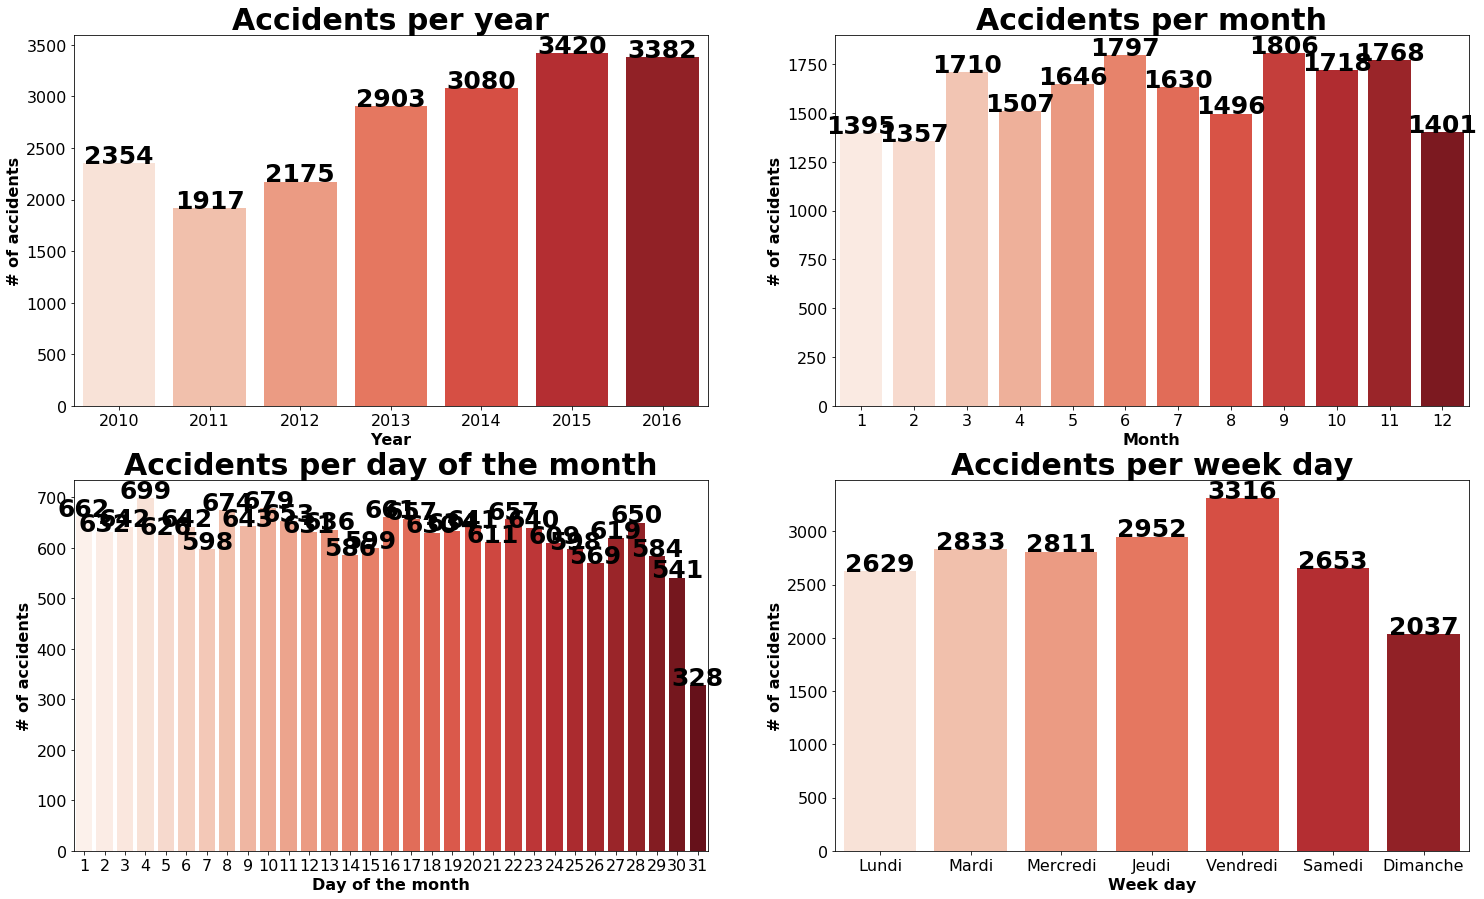

In [9]:
fig = plt.figure(figsize=(25,15))

# Visualize accidents per Year
ax1 = fig.add_subplot(221)
acc_per_year = acc_df.YEAR.value_counts(ascending=True, sort=False)
ax1 = sns.barplot(x=acc_per_year.index, 
                 y=acc_per_year, 
                 palette='Reds',
                 ax=ax1)
value_barplot_label(ax1)
plt.title("Accidents per year", fontsize=30).set_weight('bold')
tick_format(ax1, 2)
ax1.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax1.set_xlabel('Year', fontsize=16).set_weight('bold')

# Visualize accidents per month
ax2 = fig.add_subplot(222)
acc_per_month = acc_df.MONTH.value_counts(ascending=True, sort=False)
ax2 = sns.barplot(x=acc_per_month.index, 
                 y=acc_per_month, 
                 palette='Reds',
                 ax=ax2)
value_barplot_label(ax2)
plt.title("Accidents per month", fontsize=30).set_weight('bold')
tick_format(ax2, 2)
ax2.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax2.set_xlabel('Month', fontsize=16).set_weight('bold')

# Visualize accidents per day of the month
ax3 = fig.add_subplot(223)
acc_per_day = acc_df.DAY.value_counts(ascending=True, sort=False)
ax3 = sns.barplot(x=acc_per_day.index, 
                 y=acc_per_day, 
                 palette='Reds',
                 ax=ax3)
value_barplot_label(ax3)
plt.title("Accidents per day of the month", fontsize=30).set_weight('bold')
tick_format(ax3, 2)
ax3.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax3.set_xlabel('Day of the month', fontsize=16).set_weight('bold')

# Visualize accidents per weekday
ax4 = fig.add_subplot(224)
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_df.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds',
                 ax=ax4)
value_barplot_label(ax4)
plt.title("Accidents per week day", fontsize=30).set_weight('bold')
tick_format(ax4, 2)
ax4.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=16).set_weight('bold')


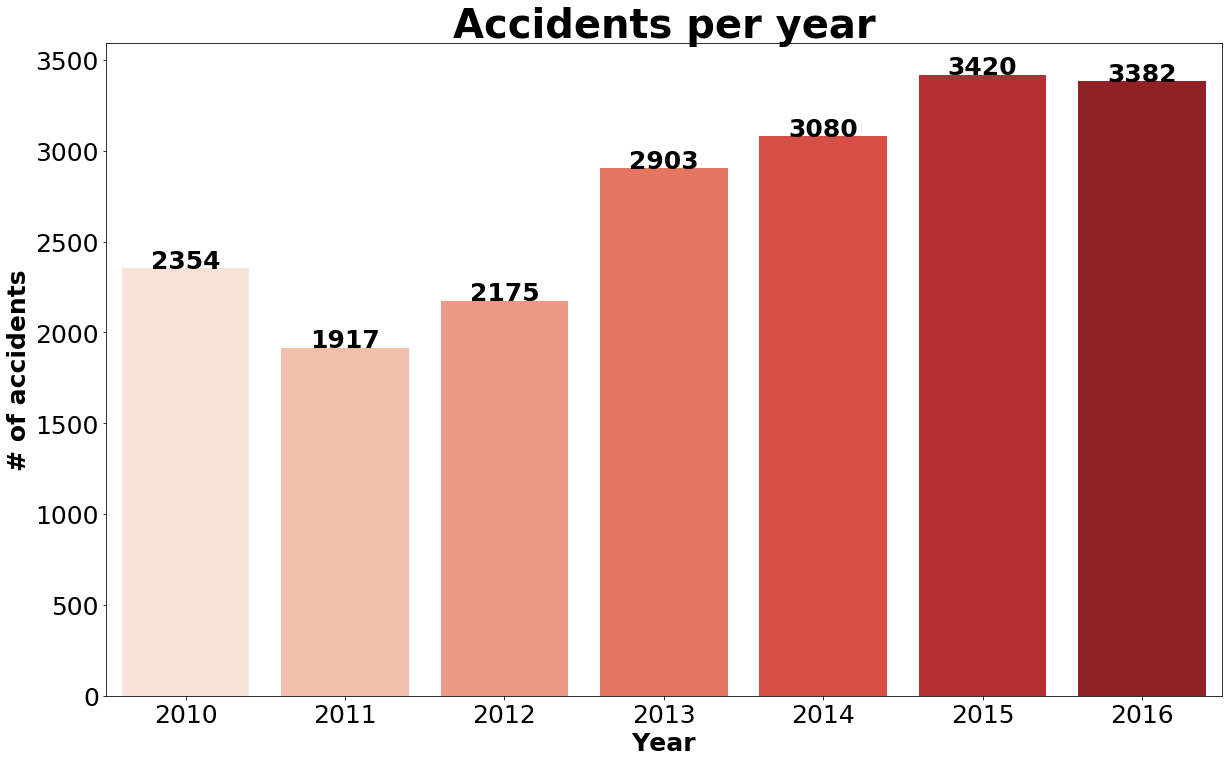

In [10]:
# Accidents per year
fig = plt.figure(figsize=(20,12))

# Visualize accidents per Year
acc_per_year = acc_df.YEAR.value_counts(ascending=True, sort=False)
ax1= sns.barplot(x=acc_per_year.index, 
                 y=acc_per_year, 
                 palette='Reds')
value_barplot_label(ax1)
plt.title("Accidents per year", fontsize=40).set_weight('bold')
tick_format(ax1, 4)
ax1.set_ylabel('# of accidents', fontsize=25).set_weight('bold')
ax1.set_xlabel('Year', fontsize=25).set_weight('bold')

pylab.savefig('Images/acc_year.png')

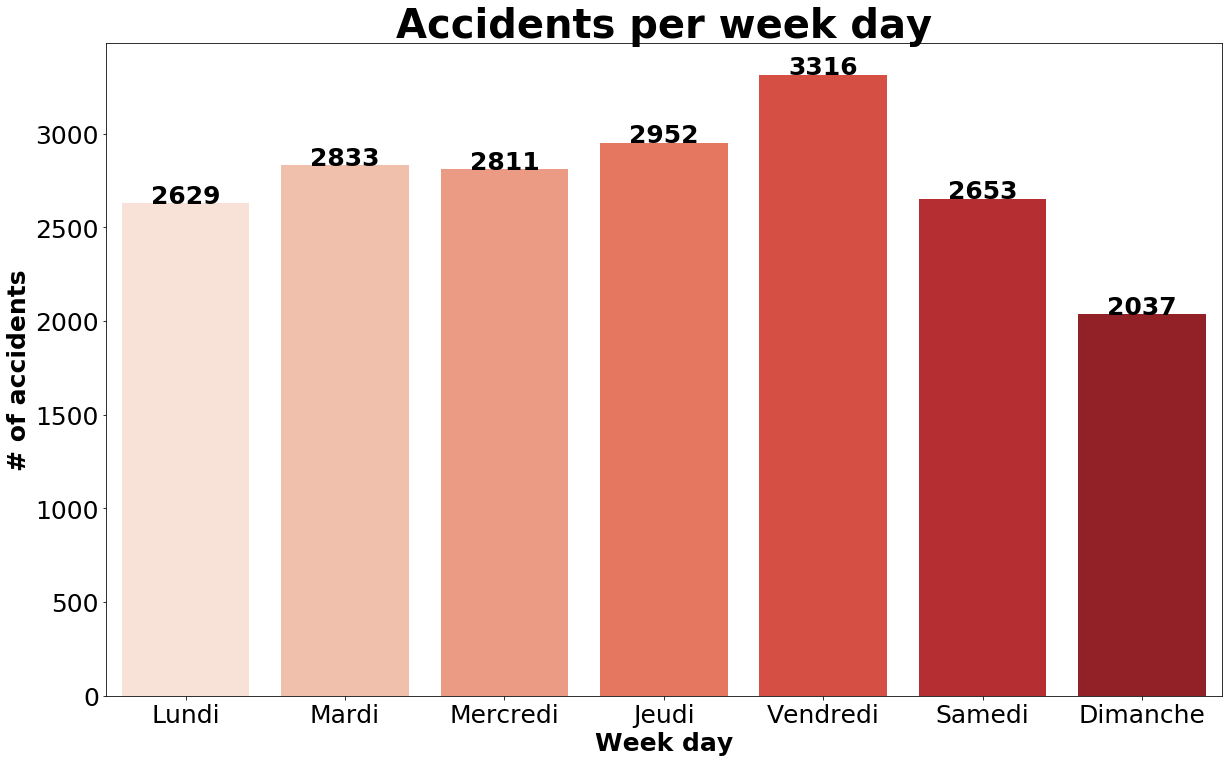

In [11]:
# Accidents per year
fig = plt.figure(figsize=(20,12))

# Visualize accidents per Year
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_df.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds')
value_barplot_label(ax4)
plt.title("Accidents per week day", fontsize=40).set_weight('bold')
tick_format(ax4, 4)
ax4.set_ylabel('# of accidents', fontsize=25).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=25).set_weight('bold')

pylab.savefig('Images/acc_weekday.png')

From the plots above we can draw some first observations of the time features:
- There is an observable **increase of number of accidents** between 2011 to 2015. In 2016, there is a neglegible decrease.
- During the year, it can be observed some up-downs. There is a **peak of accidents** in March, June, September, October and November. Our first guess is that during the months when holidays start or end, it is more probable to have an accident. A further analysis could be done in order to verify the first assumption by getting the information of the year holidays and seeing the correlation with the accidents dates. 
- During the differents months of the year, there is no appreciable correlation within the month and the probability to have an accident.
- However, during the week, the days with higher probability to have an accident are Thurstday and Friday. 

From this last conslusion, the evolution during the years of the days of the week with higher probability to have an accident will be investigated:

In [12]:
# Compute number of accidents per day of the week and per year
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
years = np.arange(2010,2017,1)
per_weekday_per_year_df = pd.DataFrame()
for y in years:
    string = str(y)
    per_weekday_per_year_df[string] = acc_df[acc_df['YEAR']==y].JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
per_weekday_per_year_df


,2010,2011,2012,2013,2014,2015,2016
Lundi,303,261,313,424,422,462,444
Mardi,346,272,328,442,488,483,474
Mercredi,356,293,312,427,452,492,479
Jeudi,361,308,317,450,456,493,567
Vendredi,424,330,348,453,530,619,612
Samedi,309,240,332,394,428,478,472
Dimanche,255,213,225,313,304,393,334


In [13]:
pd.crosstab(acc_df.JOUR, acc_df.YEAR, margins=False).style.background_gradient(cmap='summer_r')

YEAR,2010,2011,2012,2013,2014,2015,2016
JOUR,,,,,,,
Dimanche,255,213,225,313,304,393,334
Jeudi,361,308,317,450,456,493,567
Lundi,303,261,313,424,422,462,444
Mardi,346,272,328,442,488,483,474
Mercredi,356,293,312,427,452,492,479
Samedi,309,240,332,394,428,478,472
Vendredi,424,330,348,453,530,619,612


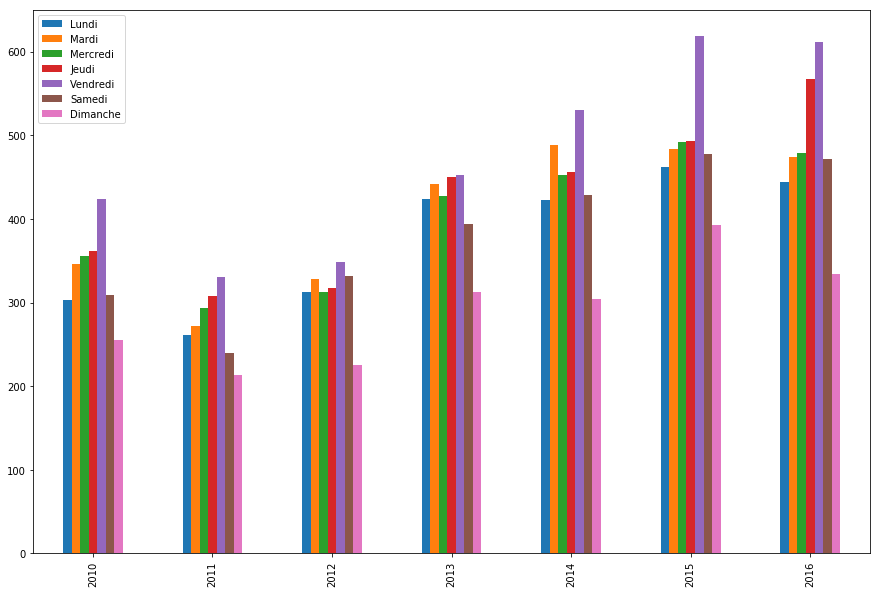

In [14]:
# Visualize the evolution
per_weekday_per_year_df=per_weekday_per_year_df.transpose()
per_weekday_per_year_df.plot.bar(figsize=(15,10))

From the plot above we can draw that during the years, there is an **relative increase** of the proportion of **accidents on Friday**.

In order to get more time information and help to drow better conclusions, the `DayTime` and `SEASON` will be created.

The `DayTime` feature is defined from the feature `HOUR` as follows:
- From 22 to 6: **Night**
- From 6 to 11: **Morning**
- From 11 to 13: **Mid-day**
- From 13 to 17: **Afternoon**
- From 17 to 22: **Evening**

The `SEASON` feature is defined from the feature `MONTH` as follows:
- From December to March: **Winter**
- From April to June: **Spring**
- From July to August: **Summer**
- From September to November: **Autumn**

It is importe to note that this classes are unbalanced. However, represent better the real world as can define the kind of travels of people that have an accident.

In [15]:
# Bin by daytime
bins = (-0.1, 5, 10, 13, 17, 22, 24.1)
daytime_names = ['Night', 'Morning', 'Mid-day', 'Afternoon','Evening', 'Night']
daytime = pd.cut(acc_df.HOUR, bins, labels=daytime_names)
acc_df['DayTime'] = daytime

In [16]:
# Bin by season
bins = (0, 3, 6, 8, 11, 12.1)
season_names = ['Winter', 'Spring', 'Summer', 'Autumn', 'Winter']
season = pd.cut(acc_df.MONTH, bins, labels=season_names)
acc_df['SEASON'] = season

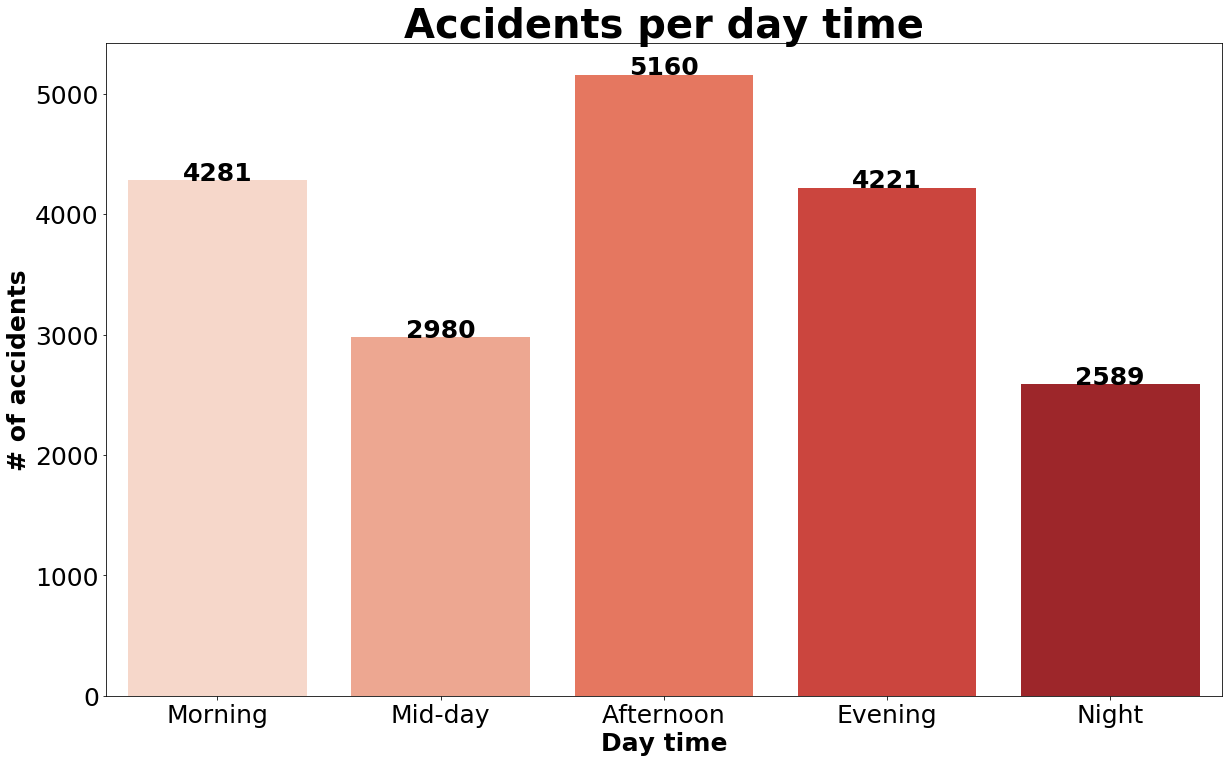

In [17]:
# Compute number of accidents per day of the week and per year
daytime_names_order = ['Morning', 'Mid-day', 'Afternoon','Evening', 'Night']
# Accidents per year
fig = plt.figure(figsize=(20,12))

# Visualize accidents per Year
daytime_names_order = ['Morning', 'Mid-day', 'Afternoon','Evening', 'Night']
acc_daytime_viz = acc_df.DayTime.value_counts(ascending=True, sort=False).reindex(daytime_names_order)
ax4 = sns.barplot(x=acc_daytime_viz.index, 
                 y=acc_daytime_viz, 
                 palette='Reds')
value_barplot_label(ax4)
plt.title("Accidents per day time", fontsize=40).set_weight('bold')
tick_format(ax4, 4)
ax4.set_ylabel('# of accidents', fontsize=25).set_weight('bold')
ax4.set_xlabel('Day time', fontsize=25).set_weight('bold')

pylab.savefig('Images/acc_daytime.png')

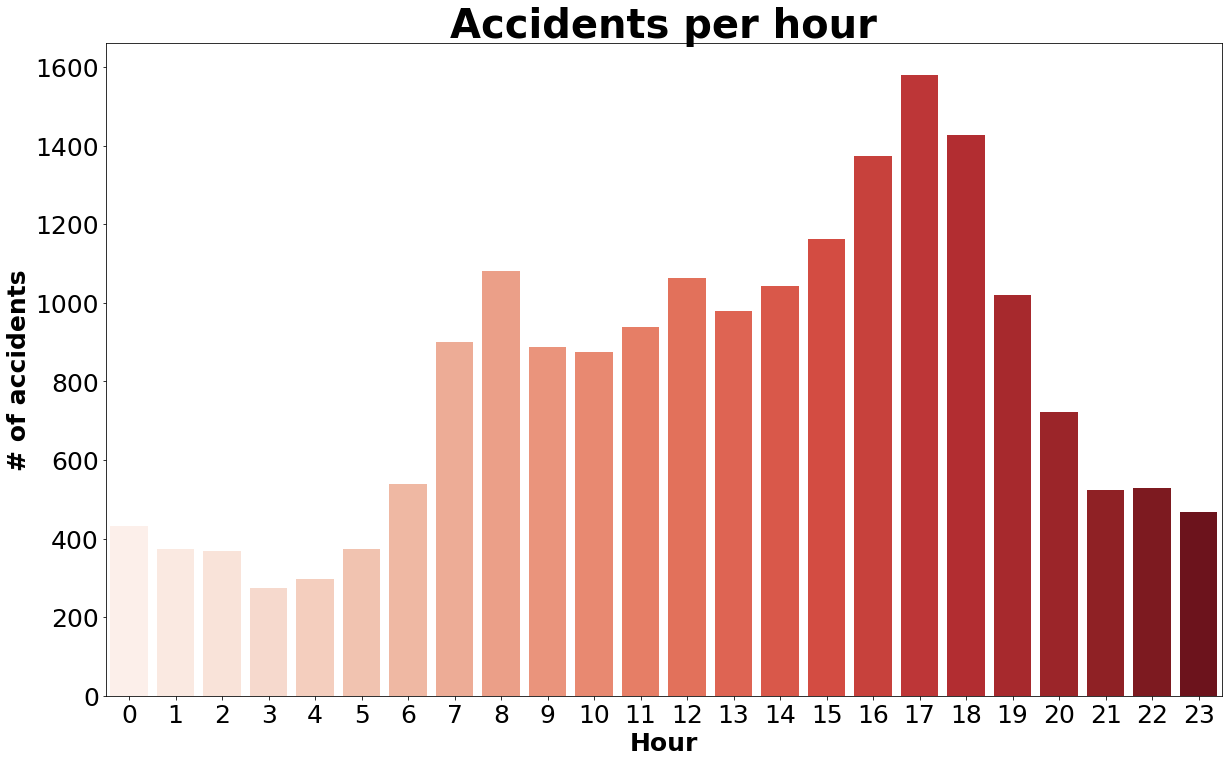

In [18]:
# Compute number of accidents per day of the week and per year
# Accidents per year
fig = plt.figure(figsize=(20,12))

# Visualize accidents per Year
acc_Hour = acc_df.HOUR.value_counts(ascending=True, sort=False)
ax4 = sns.barplot(x=acc_Hour.index, 
                 y=acc_Hour, 
                 palette='Reds')
#value_barplot_label(ax4)
plt.title("Accidents per hour", fontsize=40).set_weight('bold')
tick_format(ax4, 4)
ax4.set_ylabel('# of accidents', fontsize=25).set_weight('bold')
ax4.set_xlabel('Hour', fontsize=25).set_weight('bold')

pylab.savefig('Images/acc_hour.png')

Let's visualize the accident dataset with the time features:

In [19]:
# Visualize the time features
time_features = ['DATE_','YEAR', 'MONTH', 'DAY','JOUR', 'HOUR', 'DayTime', 'SEASON']
acc_df[time_features].head(3)

,DATE_,YEAR,MONTH,DAY,JOUR,HOUR,DayTime,SEASON
0,2010-11-30,2010,11,30,Mardi,21,Evening,Autumn
1,2010-12-08,2010,12,8,Mercredi,14,Afternoon,Winter
2,2010-12-02,2010,12,2,Jeudi,10,Morning,Winter


In [20]:
# Month cross Daytime
pd.crosstab(acc_df.MONTH, acc_df.DayTime, margins=False).style.background_gradient(cmap='summer_r')

DayTime,Afternoon,Evening,Mid-day,Morning,Night
MONTH,,,,,
1,322,310,203,355,205
2,367,289,211,300,190
3,473,360,282,383,212
4,443,302,247,320,195
5,445,342,263,377,219
6,494,410,269,403,221
7,442,381,258,317,232
8,405,314,226,308,243
9,501,412,260,405,228


In [21]:
# Hour cross year
pd.crosstab(acc_df.HOUR, acc_df.YEAR, margins=False).style.background_gradient(cmap='summer_r')

YEAR,2010,2011,2012,2013,2014,2015,2016
HOUR,,,,,,,
0,59,49,48,75,69,68,65
1,38,43,44,66,57,73,53
2,39,27,44,63,73,67,56
3,37,36,32,33,40,51,46
4,28,25,47,53,43,50,51
5,49,34,48,74,52,60,56
6,73,43,62,83,90,79,109
7,99,95,113,139,154,152,148
8,136,117,120,153,187,170,198


In [22]:
# Hour cross year
pd.crosstab(acc_df.HOUR, acc_df.MONTH, margins=False).style.background_gradient(cmap='summer_r')

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
HOUR,,,,,,,,,,,,
0,31,26,33,30,34,40,47,44,44,36,41,27
1,33,33,28,23,30,35,37,40,30,31,28,26
2,31,21,22,27,37,26,37,29,32,38,38,31
3,24,15,23,28,20,13,28,26,29,15,28,26
4,29,30,29,22,27,18,16,25,25,32,21,23
5,30,35,37,28,30,33,27,29,23,34,26,41
6,50,34,36,43,34,52,40,39,56,58,55,42
7,83,68,79,67,84,79,62,49,79,97,93,60
8,93,64,98,88,101,102,74,67,110,100,118,66


## 2.2 Localisation
<a id='322Localisation'></a>

An other important question to ask is **WHERE** the accidents happen. 
 
As localisation features, it can be found:
- `COOR_X`: X coordenate in 'epsg_2056' reference system
- `COOR_Y`: X coordenate in 'epsg_2056' reference system
- `E`,`N`: Gives the same informationa as COOR_X and COOR_Y
- `COMMUNE`: The commune where the accident have happened
- `LOCALITE `: Gives the information if the accident happened on the outskirts of the locaity or inside.

COOR_X and COOR_Y coordenates will be projected in the GPS coordenates, also called 'epsg:4326' reference system. For this, the Proj and transform libraries will be used:

In [23]:
# projection definition
p1 = Proj(init='epsg:2056')
p2 = Proj(init='epsg:4326')

# Helper functions
def coord_proj(acc_df,i, p1, p2):
    x1 = acc_df['COOR_X'].loc[i]
    y1 = acc_df['COOR_Y'].loc[i]
    x2, y2 = transform(p1,p2,x1,y1)
    acc_df['COOR_X'].set_value(i, x2)
    acc_df['COOR_Y'].set_value(i, y2)
    return acc_df

# Project data
for i in range(0, len(acc_df['COOR_X'])-1):
    acc_df = coord_proj(acc_df,i, p1, p2)

    # Delete unuseful columns
del acc_df['N']
del acc_df['E']
acc_df.head(3)

,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,...,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,YEAR,MONTH,DAY,HOUR,DayTime,SEASON
0,2010-11-30,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,...,0.0,0.0,0.0,0.0,2010,11,30,21,Evening,Autumn
1,2010-12-08,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,...,0.0,0.0,0.0,0.0,2010,12,8,14,Afternoon,Winter
2,2010-12-02,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,Enneigée,...,0.0,0.0,0.0,0.0,2010,12,2,10,Morning,Winter


An other localisation feature is the `COMMUNE`. In order more information to get insight of the accidents dataset, it will be interesting to have the number of inhabitants of each Commune (**To Develop**)

Let's understand in which Commune the accidents happen.

In [24]:
# Visualize the number of accidents per commune (TOP5)
acc_df.COMMUNE.value_counts().head(5)

Genève         8913
Vernier        1486
Petit-Lancy    1054
Meyrin          971
Carouge GE      858
Name: COMMUNE, dtype: int64

In [25]:
# Localité
acc_df.LOCALITE.value_counts()

A l'intérieur d'une localité    10789
Non renseigné                    6101
A l'extérieur d'une localité     2341
Name: LOCALITE, dtype: int64

In [26]:
# Hour cross year
pd.crosstab(acc_df.SEASON, acc_df.LOCALITE, margins=False).style.background_gradient(cmap='summer_r')

LOCALITE,A l'extérieur d'une localité,A l'intérieur d'une localité,Non renseigné
SEASON,,,
Autumn,658,2909,1725
Spring,594,2728,1628
Summer,382,1801,943
Winter,707,3351,1805


## 2.3 Conditions
<a id='323Conditions'></a>

This section investigates the question **HOW**. The external conditions of each accident will be analysed. 

In the list of external conditions we can find:
- Light conditions (`CONDITIONS_LUMINEUSES`)
- Weather conditions (`CONDITIONS_METEO`)
- Road conditions (`ETAT_ROUTE`)
- Road type (`GENRE_ROUTE`)


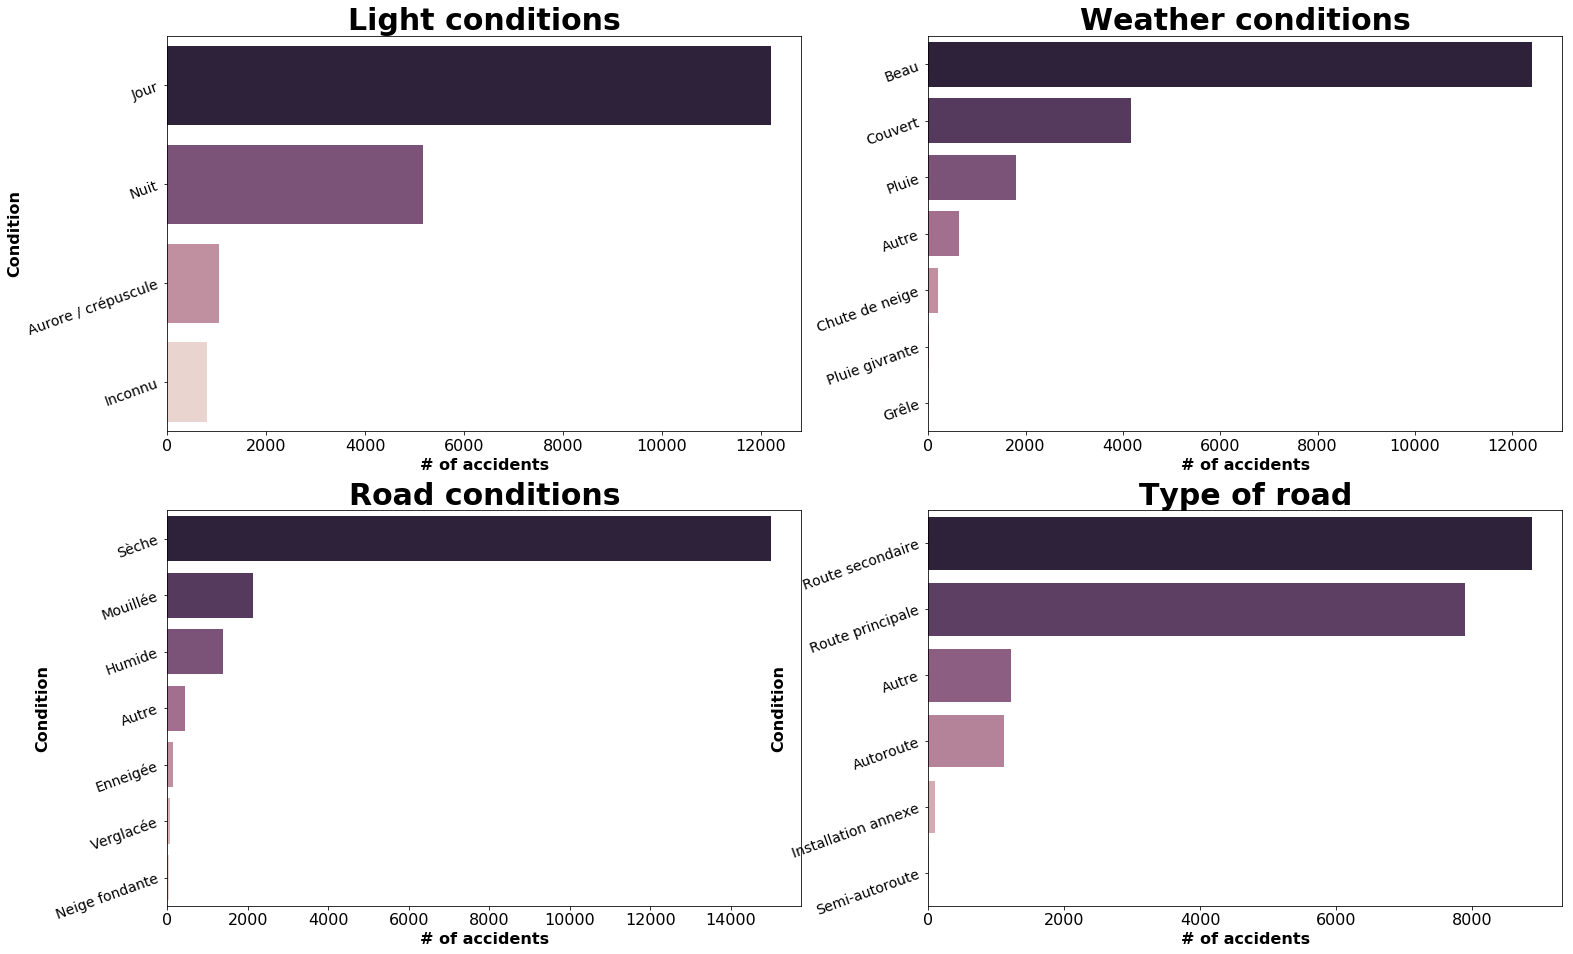

In [27]:
fig = plt.figure(figsize=(25,16))

# Visualize the accident group
ax1 = fig.add_subplot(221)
light_cond = acc_df.CONDITIONS_LUMINEUSES.value_counts()
ax1 = sns.barplot(x=light_cond, 
                 y=light_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(light_cond.index)),
                 ax=ax1)
plt.title("Light conditions", fontsize=30).set_weight('bold')
tick_format(ax1, 3)
ax1.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax1.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax2 = fig.add_subplot(222)
weather_cond = acc_df.CONDITIONS_METEO.value_counts()
ax2 = sns.barplot(x=weather_cond, 
                 y=weather_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(weather_cond.index)),
                 ax=ax2)
plt.title("Weather conditions", fontsize=30).set_weight('bold')
tick_format(ax2, 3)
ax2.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax3 = fig.add_subplot(223)
road_cond = acc_df.ETAT_ROUTE.value_counts()
ax3 = sns.barplot(x=road_cond, 
                 y=road_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(road_cond.index)),
                 ax=ax3)
plt.title("Road conditions", fontsize=30).set_weight('bold')
tick_format(ax3, 3)
ax3.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax3.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax4 = fig.add_subplot(224)
road_type = acc_df.GENRE_ROUTE.value_counts()
ax4 = sns.barplot(x=road_type, 
                 y=road_type.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(road_type.index)),
                 ax=ax4)
plt.title("Type of road", fontsize=30).set_weight('bold')
tick_format(ax4, 3)
ax4.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax4.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


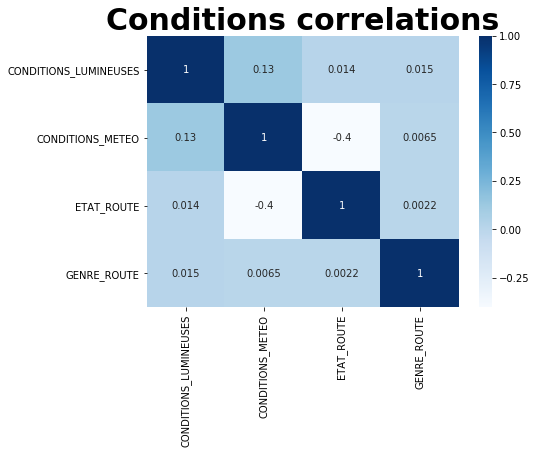

In [28]:
# Search for correlations on conditions features (categorical)
conditions_features = ['CONDITIONS_LUMINEUSES', 'CONDITIONS_METEO', 'ETAT_ROUTE', 'GENRE_ROUTE']
conditions = acc_df[conditions_features]

# Encode features to
from sklearn.preprocessing import LabelEncoder

for feature in conditions_features:
    le = LabelEncoder()
    le = le.fit(conditions[feature])
    conditions[feature] = le.transform(conditions[feature])

# Compute and visualize correlations
fig = plt.figure(figsize=(7,5))
plt.title('Conditions correlations', fontsize=30).set_weight('bold')
ax = sns.heatmap(conditions.corr(), cmap="Blues", annot=True)

From the heatmap above, it can be observed that **light conditions** and **meteo conditions** are slightly correlated when talking about context of accidents.

## 2.4 Accident type
<a id='324Accident'></a>

And important question to answer is **WHY**. The main causes for each accident group/type will be described in this section.

Three main features will be analysed in this section:
- `GROUPE_ACCIDENT`
- `CAUSE`


Let's start analysing the accident group.

### 2.4.1 Accident group

In [29]:
groupe_accidents = acc_df.GROUPE_ACCIDENT.value_counts()
groupe_accidents.index
gp_acc= ['Dérapage ou perte de maîtrise', 'Accident par tamponnement',
       'Accident en parquant',
       'Accident lors d\'un dépassement ou\n lors d\'un changement de voie de circulation',
       'Accident en traversant une route', 'Accident en quittant une route',
       'Accident impliquant des piétons',
       'Accident en s\'engageant sur une route', 'Collision frontale', 'Autres',
       'Accident impliquant des animaux']

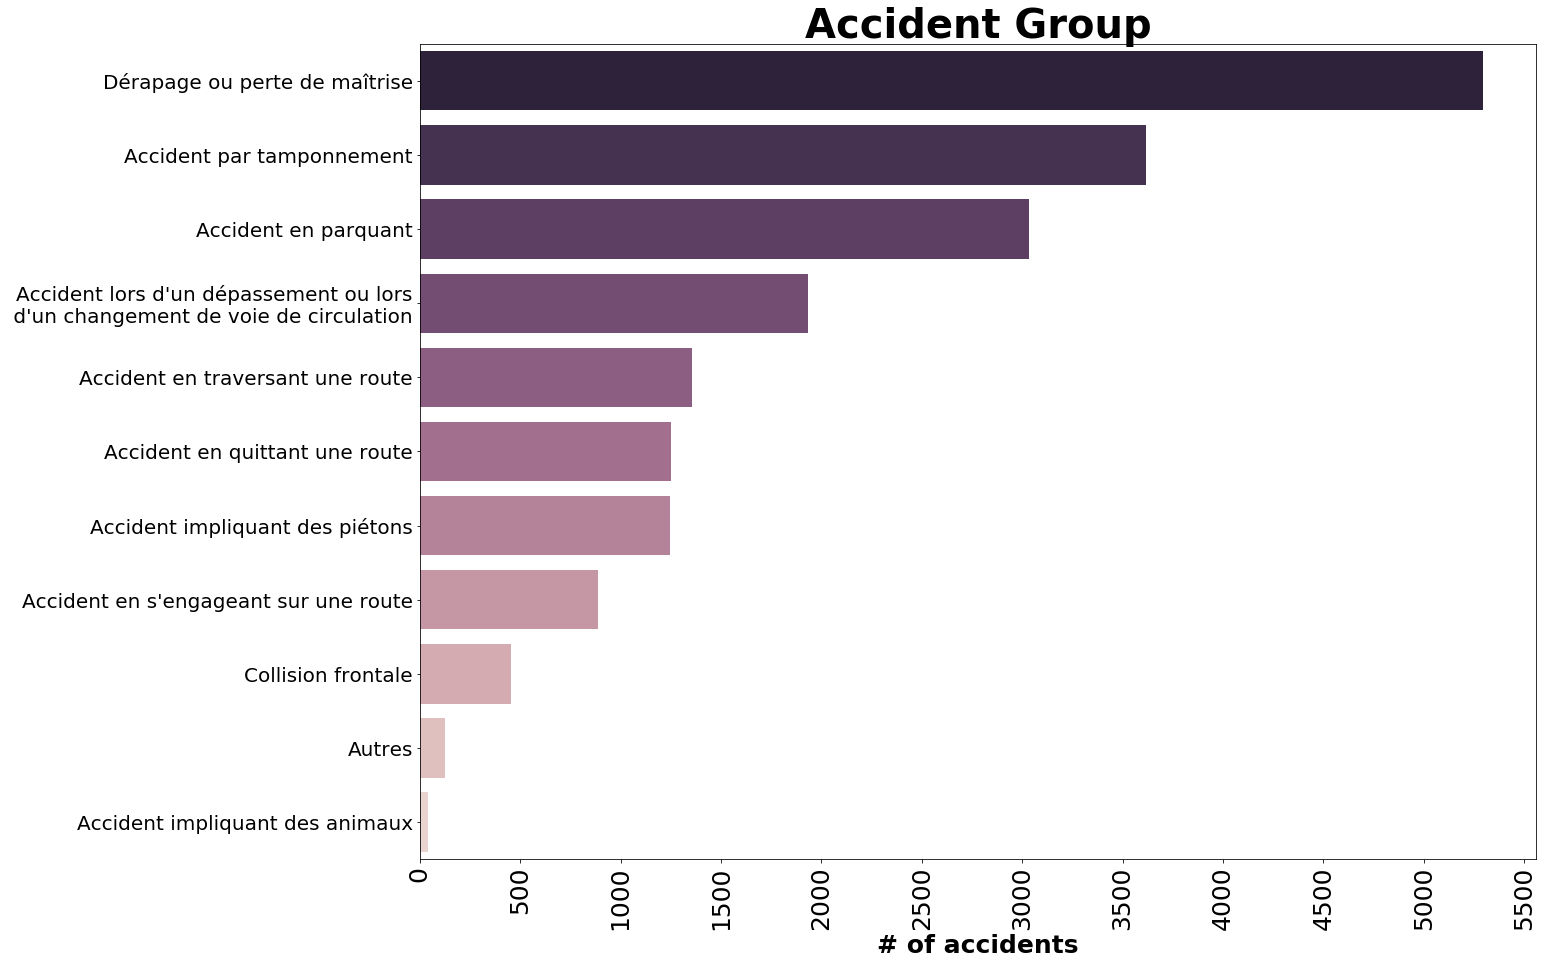

In [30]:
# Visualize the accident group
plt.figure(figsize=(20,15))
groupe_accidents = acc_df.GROUPE_ACCIDENT.value_counts()
gp_acc= ['Dérapage ou perte de maîtrise', 'Accident par tamponnement',
       'Accident en parquant',
       'Accident lors d\'un dépassement ou lors\n d\'un changement de voie de circulation',
       'Accident en traversant une route', 'Accident en quittant une route',
       'Accident impliquant des piétons',
       'Accident en s\'engageant sur une route', 'Collision frontale', 'Autres',
       'Accident impliquant des animaux']
ax = sns.barplot(x=groupe_accidents, 
                 y=gp_acc, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)))
ax.set(xticks=np.linspace(0,5500,num=12))
#value_barplot_label(ax)
plt.title("Accident Group", fontsize=40).set_weight('bold')
tick_format(ax, 5)
#ax.set_ylabel('Accident group', fontsize=25).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=25).set_weight('bold')

#pylab.savefig('Images/acc_group.png')
fig = ax.get_figure()
fig.savefig('Images/acc_group.png', bbox_inches='tight')

By the figure above, it can be identified that the accident groups with more accidents are:
- Dérapage ou perte de maîtrise
- Accident par tamponnement
- Accident en parquant


### 2.4.1 Accident group cross conditions

In this section we are going to investigate the relation between the the accident group and the conditions, in particular, the following conditions:
1. Light conditions
2. Weather conditions
3. Type of road


#### 2.4.1.1 Accident group cross light conditions

**Question**: Is the group of accident dependent on the light conditions (day, evening, night, unknown)?

In other words, the group of accidents could be clustered depening the light of conditions. Let's investigate this fact:

In [31]:
# Create table
condlum_pvt = acc_df.groupby(['GROUPE_ACCIDENT', 'CONDITIONS_LUMINEUSES'])['YEAR'].count().to_frame().reset_index()

# Count the number of accidents per accident group
grouacc_valuecounts = acc_df.GROUPE_ACCIDENT.value_counts()
grouacc_valuecounts_id = acc_df.GROUPE_ACCIDENT.value_counts().index

# Compute the percentage over the group_accident total accidents
for acc, acc_counts in zip(grouacc_valuecounts_id, grouacc_valuecounts):
    condlum_pvt.YEAR[condlum_pvt.GROUPE_ACCIDENT == acc] = condlum_pvt.YEAR/acc_counts

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
# Option 1
# Count d'accidents par groupe d'accident et conditions lumneuses
#features = ['GROUPE_ACCIDENT', 'CONDITIONS_LUMINEUSES', 'YEAR']
#condlum_pvt = acc_df[features].pivot_table(index=['GROUPE_ACCIDENT', 'CONDITIONS_LUMINEUSES'], 
                             #aggfunc=len,
                            #fill_value=0)
# Option 2
#acc_df.groupby(['GROUPE_ACCIDENT', 'CONDITIONS_LUMINEUSES'])['YEAR'].count().to_frame().unstack()
# check the differences between unstack and reset_index()

# option3
pd.crosstab(acc_df.GROUPE_ACCIDENT, acc_df.CONDITIONS_LUMINEUSES, margins=False).style.background_gradient(cmap='summer_r')

CONDITIONS_LUMINEUSES,Aurore / crépuscule,Inconnu,Jour,Nuit
GROUPE_ACCIDENT,,,,
Accident en parquant,100,744,1622,567
Accident en quittant une route,61,0,958,232
Accident en s'engageant sur une route,50,3,668,165
Accident en traversant une route,86,0,947,321
Accident impliquant des animaux,3,0,16,21
Accident impliquant des piétons,76,1,880,290
Accident lors d'un dépassement ou lors d'un changement de voie de circulation,105,7,1473,349
Accident par tamponnement,181,4,2658,772
Autres,6,0,96,22


In [33]:
pd.crosstab(acc_df.GROUPE_ACCIDENT, acc_df.CONSEQUENCES, margins=False).style.background_gradient(cmap='summer_r')


CONSEQUENCES,Autres,Avec blessés graves,Avec blessés légers,Avec tués
GROUPE_ACCIDENT,,,,
Accident en parquant,2909,31,93,0
Accident en quittant une route,287,343,611,10
Accident en s'engageant sur une route,395,134,357,0
Accident en traversant une route,537,215,600,2
Accident impliquant des animaux,31,2,7,0
Accident impliquant des piétons,45,433,746,23
Accident lors d'un dépassement ou lors d'un changement de voie de circulation,1343,164,426,1
Accident par tamponnement,2208,206,1196,5
Autres,66,14,41,3


In [34]:
pd.crosstab(acc_df.GROUPE_ACCIDENT, acc_df.CONDITIONS_METEO, margins=False).style.background_gradient(cmap='summer_r')

CONDITIONS_METEO,Autre,Beau,Chute de neige,Couvert,Grêle,Pluie,Pluie givrante
GROUPE_ACCIDENT,,,,,,,
Accident en parquant,483,1866,17,511,0,156,0
Accident en quittant une route,2,886,3,263,0,97,0
Accident en s'engageant sur une route,1,590,6,200,0,89,0
Accident en traversant une route,2,886,13,308,0,143,2
Accident impliquant des animaux,0,29,0,9,0,2,0
Accident impliquant des piétons,7,818,13,273,0,136,0
Accident lors d'un dépassement ou lors d'un changement de voie de circulation,6,1328,9,446,1,144,0
Accident par tamponnement,26,2429,26,814,0,320,0
Autres,0,84,1,30,0,9,0


In [35]:
pd.crosstab(acc_df.HOUR, acc_df.CONSEQUENCES, margins=False).style.background_gradient(cmap='summer_r')

CONSEQUENCES,Autres,Avec blessés graves,Avec blessés légers,Avec tués
HOUR,,,,
0,301,50,81,1
1,257,44,71,2
2,265,37,66,1
3,207,24,43,1
4,230,29,37,1
5,264,30,71,8
6,317,66,152,4
7,464,121,313,2
8,577,142,357,5


In [265]:
features = ['GROUPE_ACCIDENT', 'CONSEQUENCES', 'YEAR']
acc_df.groupby(['GROUPE_ACCIDENT', 'HOUR'])['YEAR'].count().to_frame().unstack()

#condlum_pvt
#ax = sns.heatmap(condlum_pvt)

YEAR                \
HOUR                                                   0      1      2    
GROUPE_ACCIDENT                                                           
Accident en parquant                                 43.0   29.0   30.0   
Accident en quittant une route                       17.0    5.0    5.0   
Accident en s'engageant sur une route                 4.0   14.0    5.0   
Accident en traversant une route                     28.0   21.0   18.0   
Accident impliquant des animaux                       2.0    2.0    3.0   
Accident impliquant des piétons                      17.0    6.0    4.0   
Accident lors d'un dépassement ou lors d'un cha...   32.0   14.0   12.0   
Accident par tamponnement                            59.0   44.0   42.0   
Autres                                                1.0    NaN    2.0   
Collision frontale                                    9.0    8.0    9.0   
Dérapage ou perte de maîtrise                       221.0  231.0  239.0   

                                                                         \
HOUR                                                   3      4      5    
GROUPE_ACCIDENT                                                           
Accident en parquant                                 14.0   15.0   30.0   
Accident en quittant une route                        4.0    5.0   11.0   
Accident en s'engageant sur une route                 3.0    2.0    8.0   
Accident en traversant une route                     15.0   15.0   19.0   
Accident impliquant des animaux                       1.0    NaN    1.0   
Accident impliquant des piétons                       2.0    6.0    8.0   
Accident lors d'un dépassement ou lors d'un cha...    5.0    5.0   11.0   
Accident par tamponnement                            17.0   30.0   52.0   
Autres                                                1.0    NaN    2.0   
Collision frontale                                    6.0    6.0    8.0   
Dérapage ou perte de maîtrise                       207.0  213.0  223.0   

                                                                         \
HOUR                                                   6      7      8    
GROUPE_ACCIDENT                                                           
Accident en parquant                                 44.0  126.0  201.0   
Accident en quittant une route                       41.0   72.0   99.0   
Accident en s'engageant sur une route                17.0   52.0   57.0   
Accident en traversant une route                     36.0   84.0   79.0   
Accident impliquant des animaux                       3.0    NaN    1.0   
Accident impliquant des piétons                      23.0   71.0   74.0   
Accident lors d'un dépassement ou lors d'un cha...   45.0   90.0  124.0   
Accident par tamponnement                            76.0  150.0  193.0   
Autres                                                3.0    3.0    7.0   
Collision frontale                                    9.0   23.0   18.0   
Dérapage ou perte de maîtrise                       242.0  229.0  228.0   

                                                           ...           \
HOUR                                                   9   ...       14   
GROUPE_ACCIDENT                                            ...            
Accident en parquant                                151.0  ...    165.0   
Accident en quittant une route                       75.0  ...     71.0   
Accident en s'engageant sur une route                40.0  ...     45.0   
Accident en traversant une route                     53.0  ...     81.0   
Accident impliquant des animaux                       2.0  ...      3.0   
Accident impliquant des piétons                      59.0  ...     77.0   
Accident lors d'un dépassement ou lors d'un cha...   98.0  ...    126.0   
Accident par tamponnement                           181.0  ...    227.0   
Autres                                                8.0  ...     11.0   


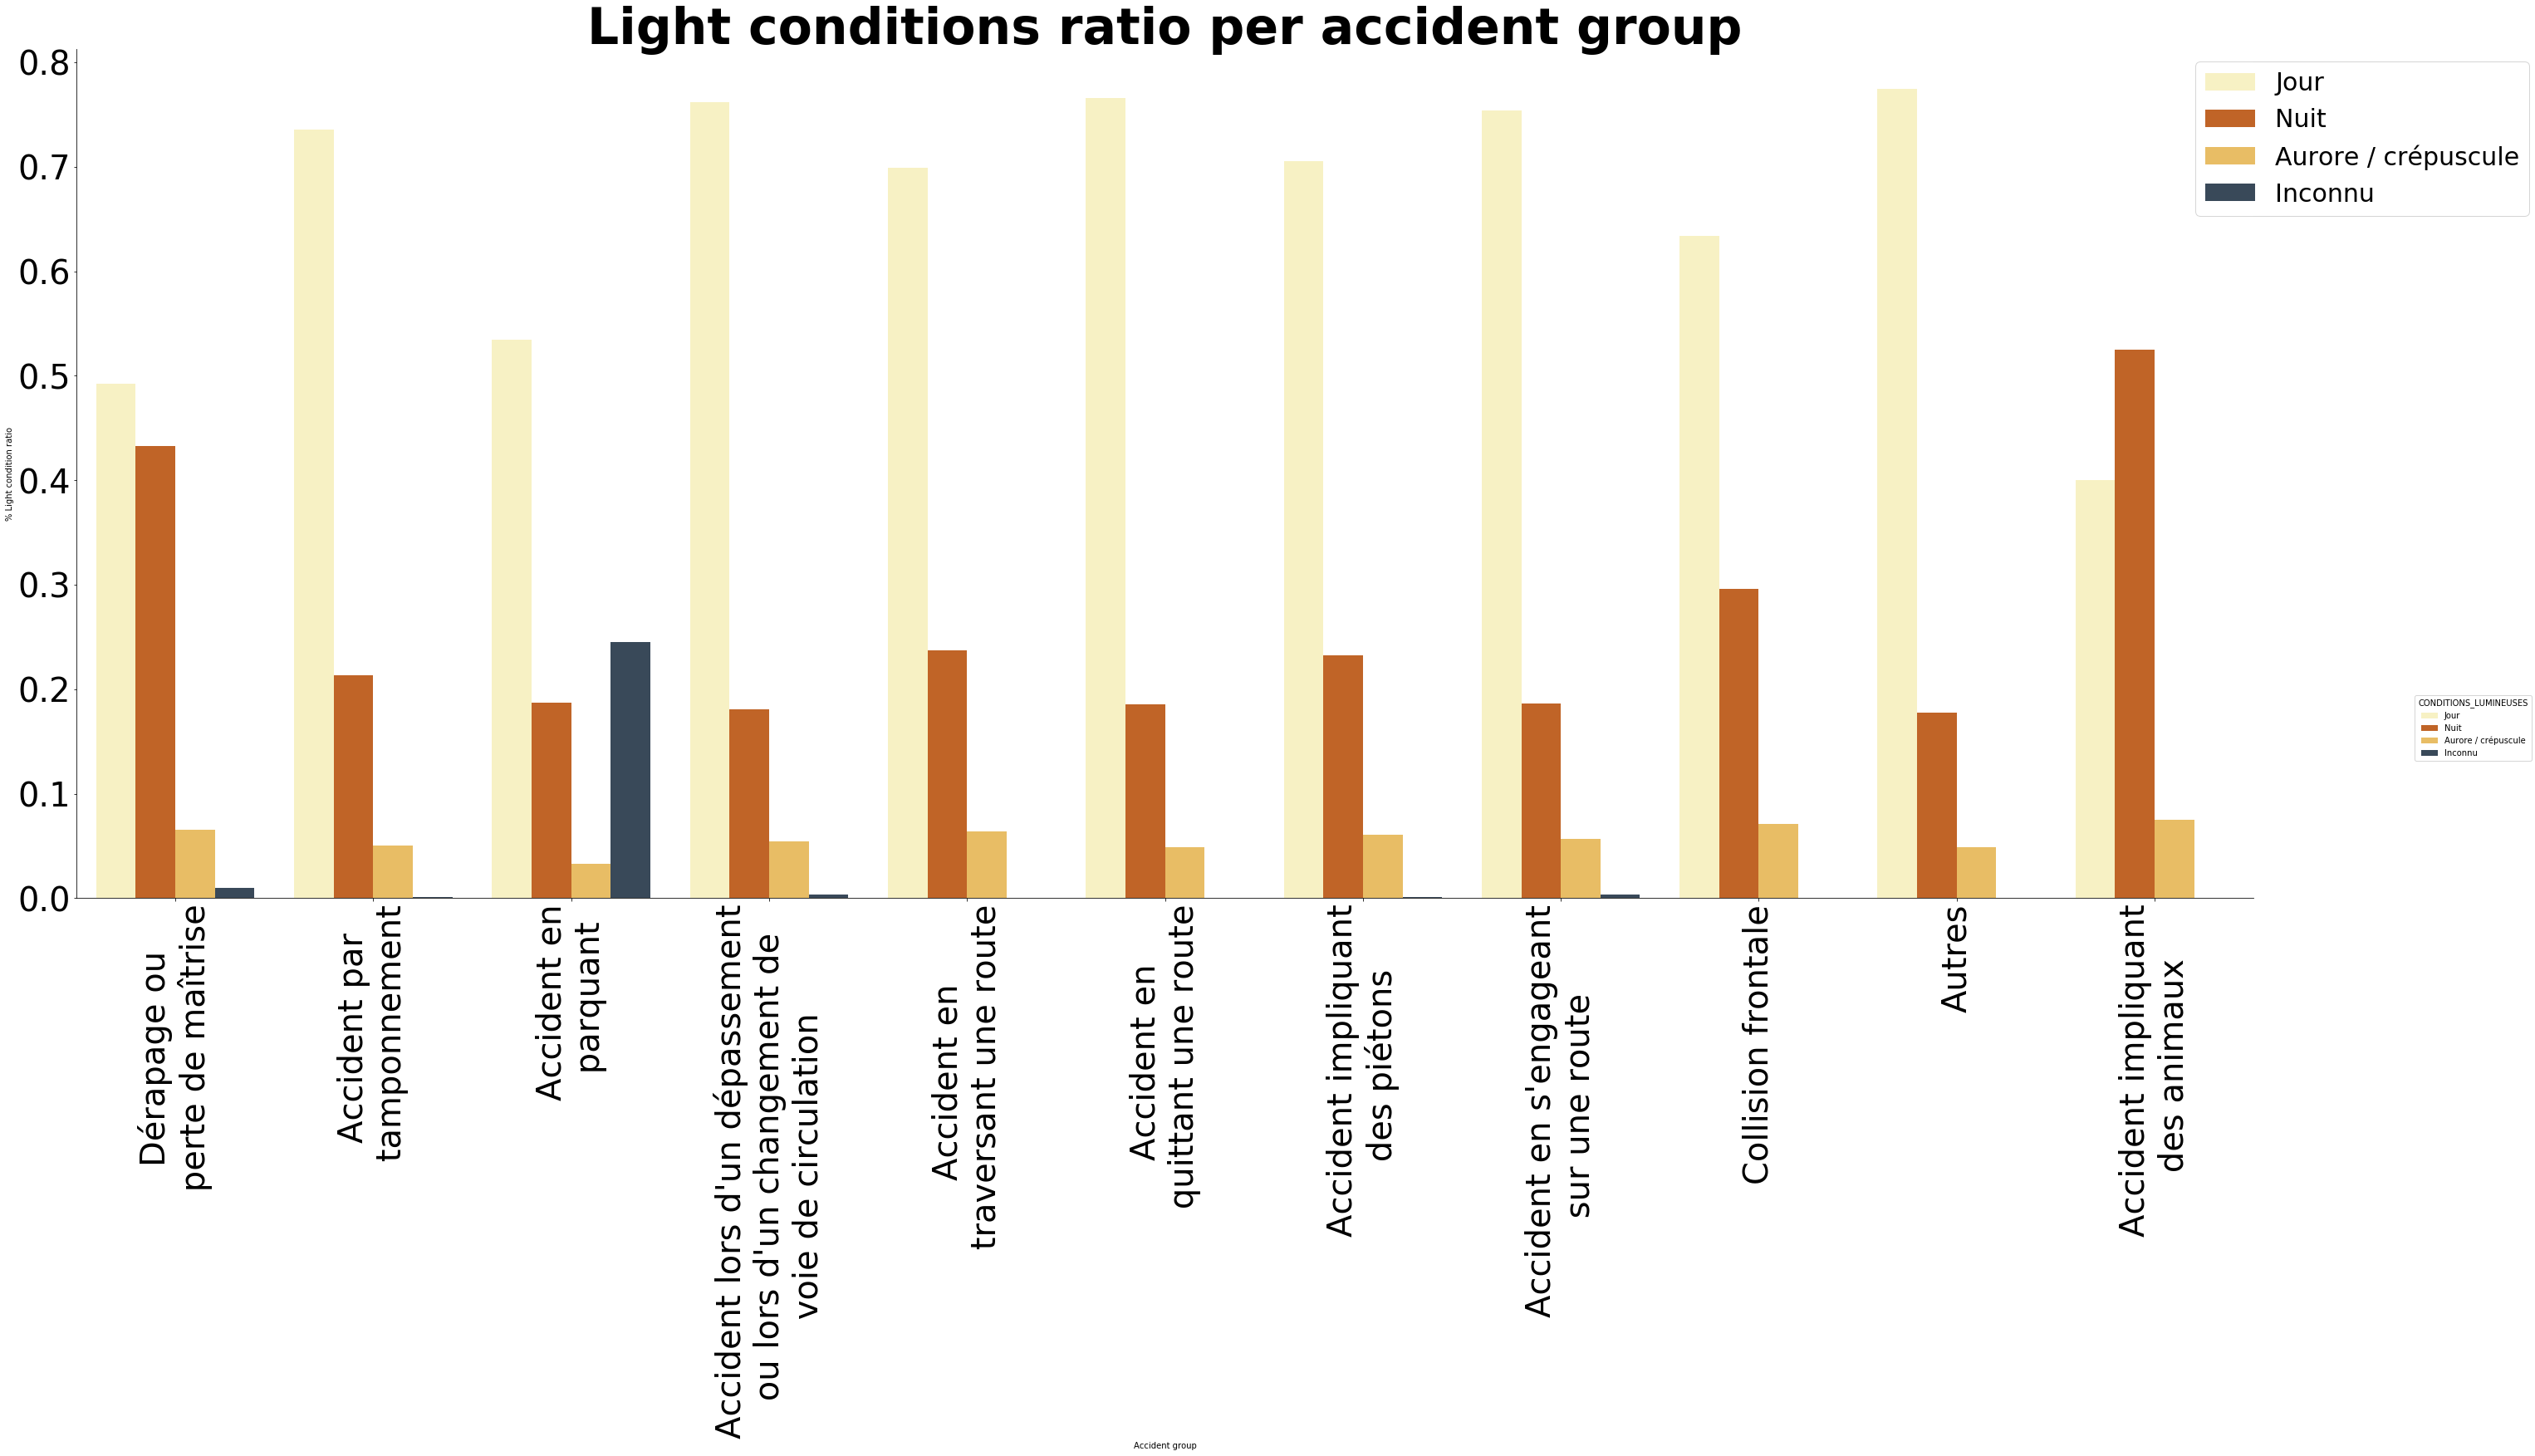

In [55]:
def xticks_accident_group():
    plt.xticks(np.linspace(0,10,11).astype(int),
           ['Dérapage ou \n perte de maîtrise', 'Accident par\n tamponnement',
            'Accident en\n parquant',
            'Accident lors d\'un dépassement\n ou lors d\'un changement de\n voie de circulation',
            'Accident en\n traversant une route', 'Accident en\n quittant une route',
            'Accident impliquant\n des piétons',
            'Accident en s\'engageant\n sur une route', 'Collision frontale', 'Autres',
            'Accident impliquant\n des animaux'])

# Visualize it in a barplot
order_groupacc = acc_df.GROUPE_ACCIDENT.value_counts().index
palette = ["#fff7bc", "#d95f0e", "#fec44f", "#34495e"]
ax = sns.factorplot(data=condlum_pvt, x="GROUPE_ACCIDENT", y="YEAR",   
                    hue="CONDITIONS_LUMINEUSES", hue_order=['Jour', 'Nuit', 'Aurore / crépuscule', 'Inconnu'],
                    order=order_groupacc,
                    legend_out=True, orient='v',
                    size=15, aspect=2.5, kind="bar", palette=palette)
xticks_accident_group()
ax.set_yticklabels(fontsize=40)
ax.set_xticklabels(fontsize=40, rotation=90)
ax.set_axis_labels("Accident group","% Light condition ratio")
plt.title('Light conditions ratio per accident group', fontsize=60).set_weight('bold')
plt
plt.legend(loc='upper center', bbox_to_anchor=(1.05,1), fontsize=30)

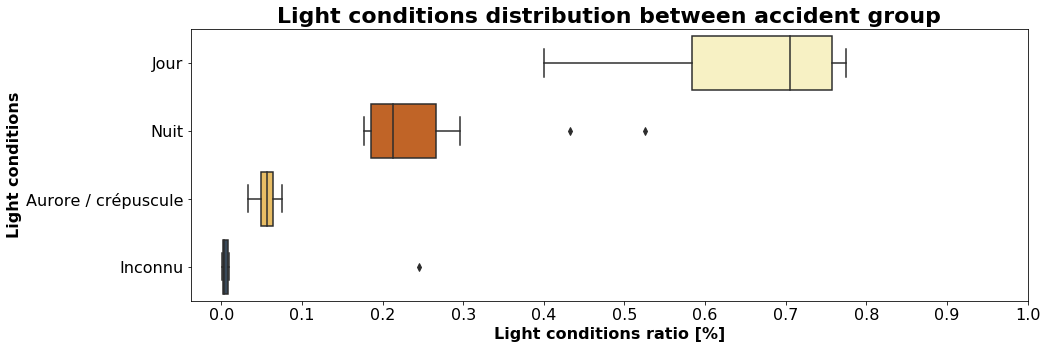

In [56]:
# See distribution between the different accident group
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="YEAR", y="CONDITIONS_LUMINEUSES", 
                 data=condlum_pvt, order=['Jour', 'Nuit', 'Aurore / crépuscule', 'Inconnu'], palette=palette)
plt.title("Light conditions distribution between accident group", fontsize=22).set_weight('bold')
tick_format(ax, 2)
ax.set(xticks=np.linspace(0,1,num=11))
ax.set_ylabel('Light conditions', fontsize=16).set_weight('bold')
ax.set_xlabel('Light conditions ratio [%]', fontsize=16).set_weight('bold')

The first remark it can be done is that the accidents light conditions classes are unbalenced. There are more accidents during the day than during the night because there is more vehicles on the roads during the day. So the way to analyse the above plot is to compare the different accidents type and investigate if there is some accident type that is quite different from the others.

* The night ratio on the `Dérapage ou perte de matîtrise`, `Accident impliquant des animaux` and `Collision frontale` accident types are higher than in other accident types. 

* The unknown light condition class is very high in `Accident en parquant`. If this is an important accident group in our further analysis this fact should be investigated to understand why it is unknown.

#### 2.4.1.2 Accident group cross weather conditions

As we did for the light conditions, let's analyse the the dependence of the weather and the accident type:

In [57]:
# Count d'accidents par groupe d'accident et weather conditions
features_weath = ['GROUPE_ACCIDENT', 'CONDITIONS_METEO', 'YEAR']

# Select the main weather conditions
select_weath = ['Beau', 'Couvert', 'Pluie', 'Autre']
acc_modified = acc_df[acc_df.CONDITIONS_METEO.isin(select_weath)]

acc_df[acc_df.CONDITIONS_METEO.isin(select_weath)]
weathcond_pvt = acc_modified[features_weath].pivot_table(index=['GROUPE_ACCIDENT', 'CONDITIONS_METEO'], 
                             aggfunc=len,
                            fill_value=0)
# Reset index
weathcond_pvt = weathcond_pvt.reset_index()

# Compute the percentage over the group_accident total accidents
for acc, acc_counts in zip(grouacc_valuecounts_id, grouacc_valuecounts):
    weathcond_pvt.YEAR[weathcond_pvt.GROUPE_ACCIDENT == acc] = weathcond_pvt.YEAR/acc_counts

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


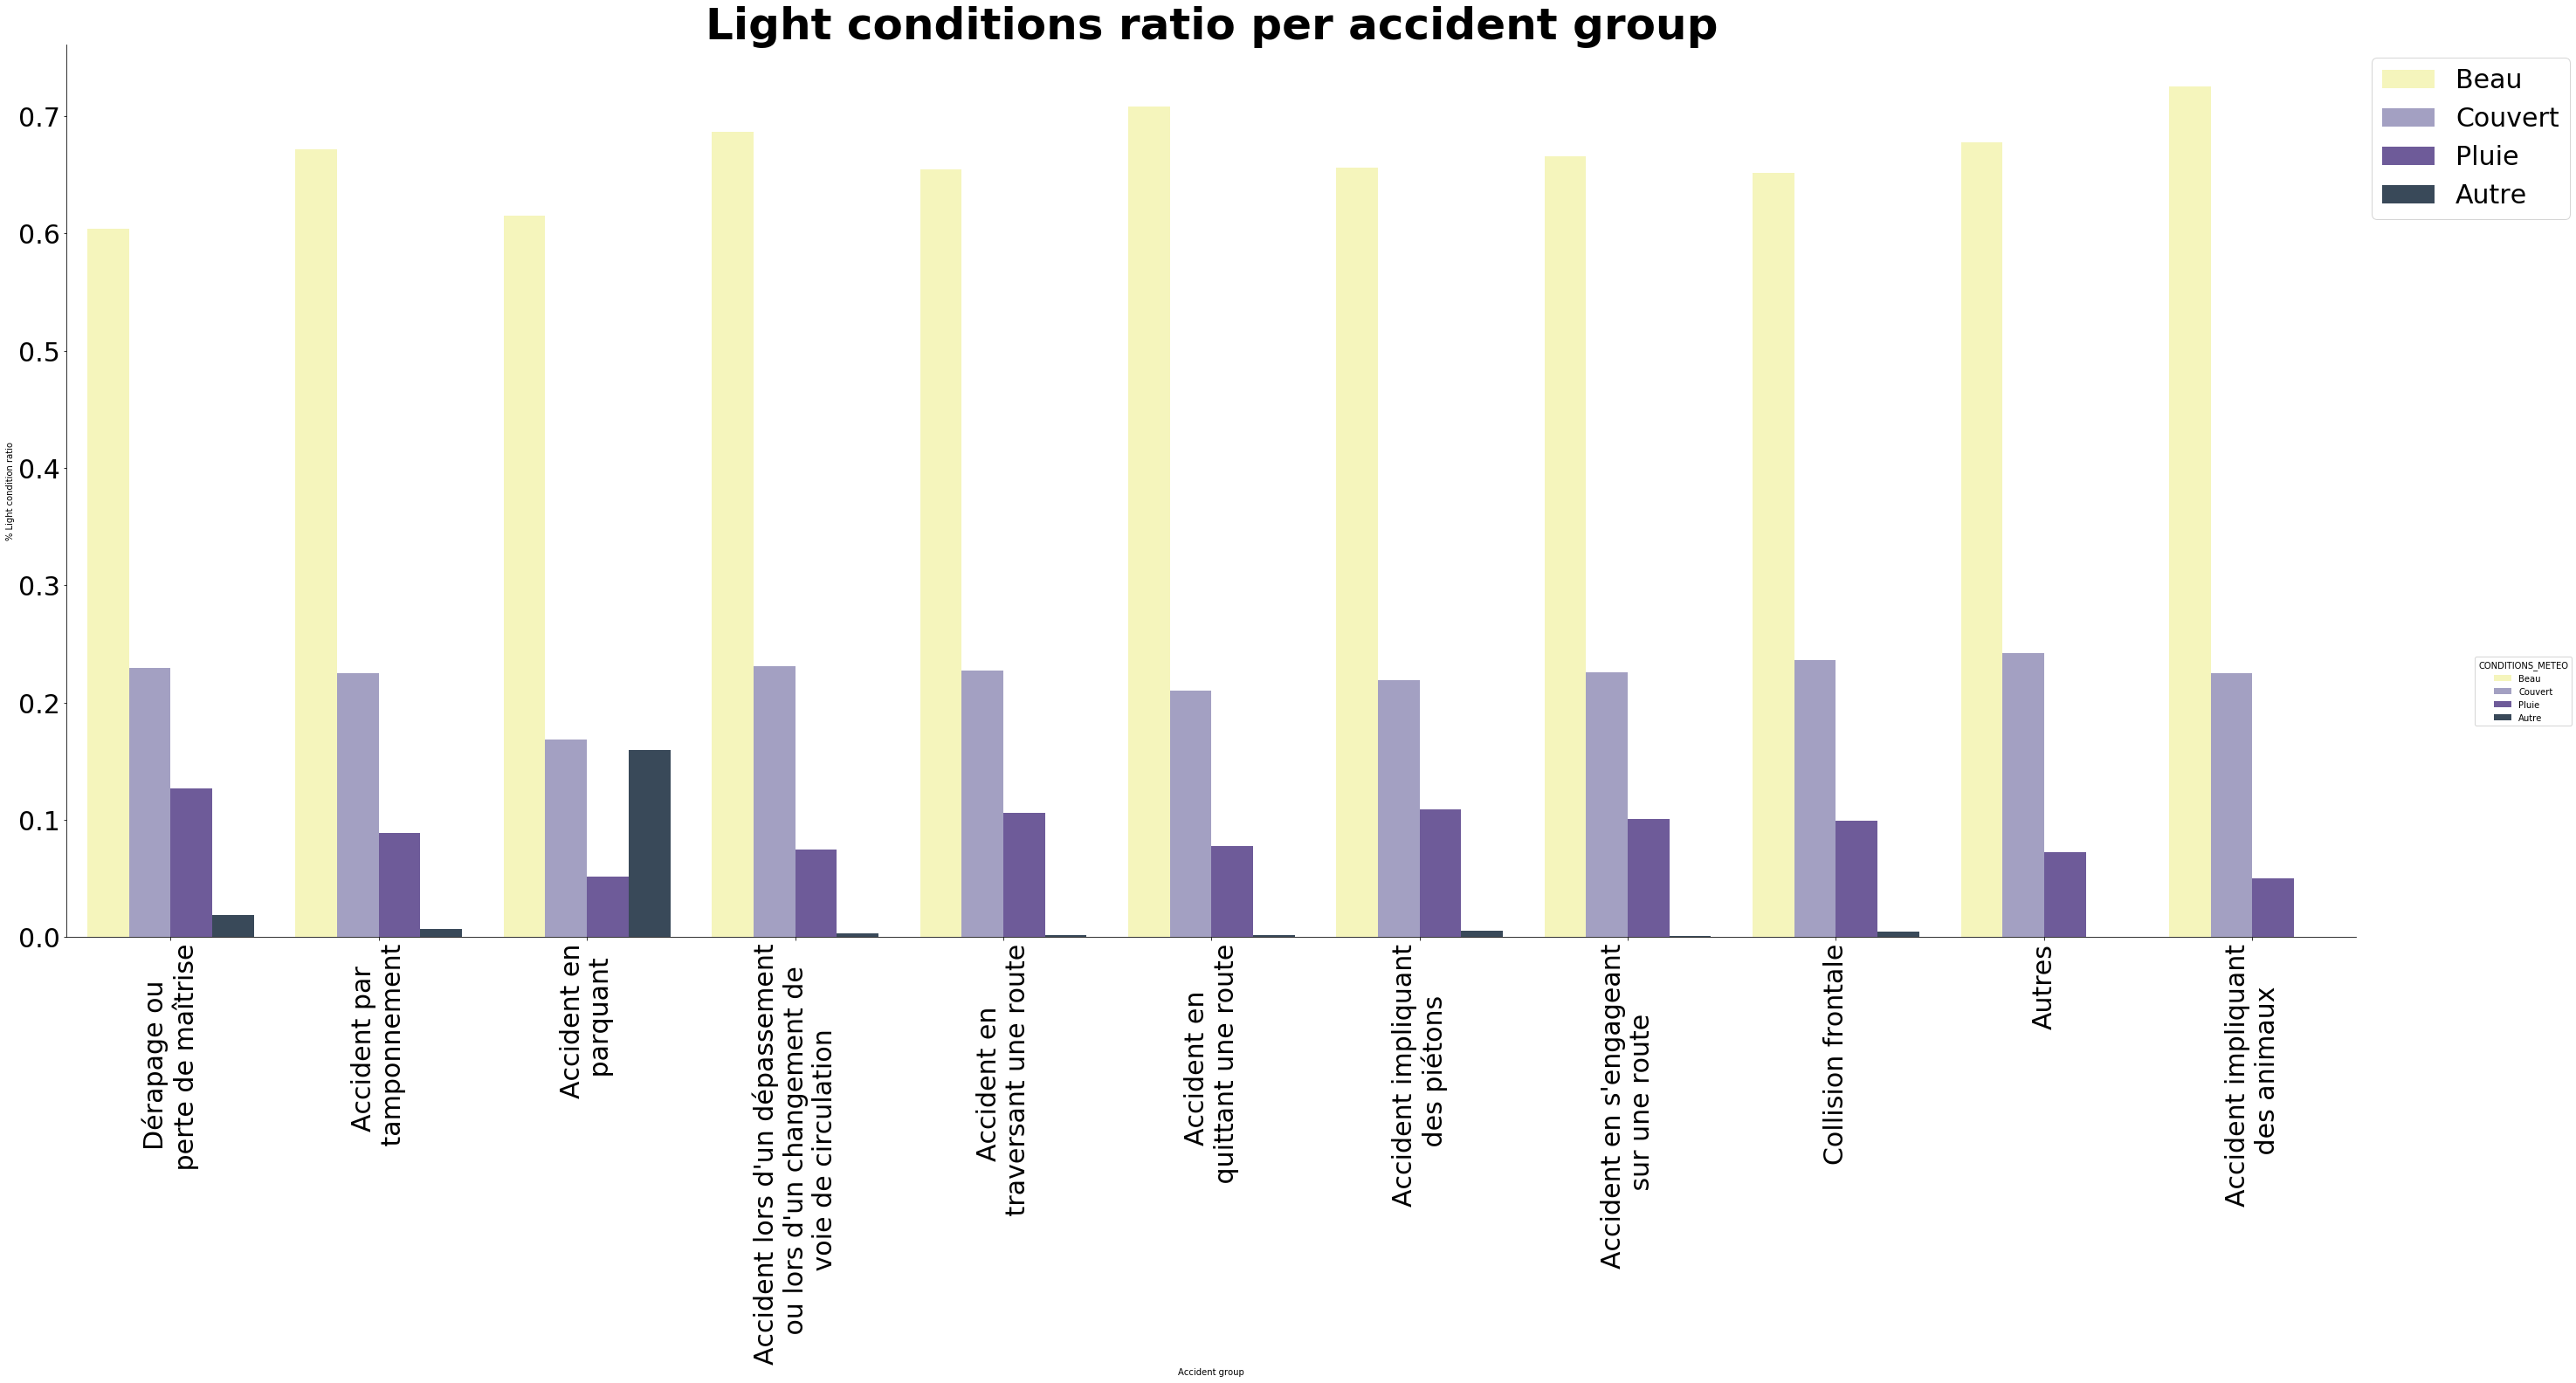

In [58]:
# Visualize it 
order_groupacc = acc_df.GROUPE_ACCIDENT.value_counts().index
palette = ["#ffffb2", "#9e9ac8", "#6a51a3", "#34495e"]
ax = sns.factorplot(data=weathcond_pvt, x="GROUPE_ACCIDENT", y="YEAR",   
                    hue="CONDITIONS_METEO", 
                    hue_order=['Beau', 'Couvert', 'Pluie', 'Autre'],
                    order=order_groupacc,
                    legend_out=True, orient='v',
                    size=15, aspect=2.5, kind="bar", palette=palette)

xticks_accident_group()
ax.set_yticklabels(fontsize=30)
ax.set_xticklabels(fontsize=30, rotation=90)
ax.set_axis_labels("Accident group","% Light condition ratio")
plt.title('Light conditions ratio per accident group', fontsize=50).set_weight('bold')
plt
plt.legend(loc='upper center', bbox_to_anchor=(1.05,1), fontsize=30)

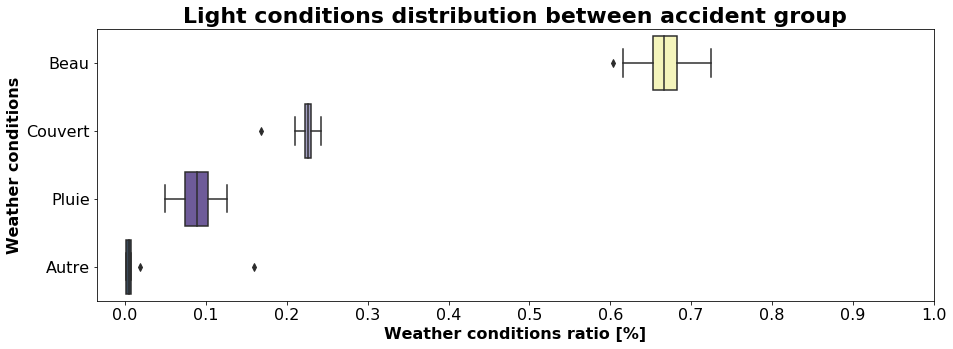

In [59]:
# See distribution between the different accident group
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="YEAR", y="CONDITIONS_METEO", 
                 data=weathcond_pvt, order=['Beau', 'Couvert', 'Pluie', 'Autre'], palette=palette)
plt.title("Light conditions distribution between accident group", fontsize=22).set_weight('bold')
tick_format(ax, 2)
ax.set(xticks=np.linspace(0,1,num=11))
ax.set_ylabel('Weather conditions', fontsize=16).set_weight('bold')
ax.set_xlabel('Weather conditions ratio [%]', fontsize=16).set_weight('bold')

#### 2.4.1.3 Accident group cross type of road

In [60]:
acc_df.GENRE_ROUTE.value_counts().index

Index(['Route secondaire', 'Route principale', 'Autre', 'Autoroute',
       'Installation annexe', 'Semi-autoroute'],
      dtype='object')

In [61]:
# Count d'accidents by accident group and type of road
order_groupacc = acc_df.GROUPE_ACCIDENT.value_counts().index
features_road = ['GROUPE_ACCIDENT', 'GENRE_ROUTE', 'YEAR']

# Select the main weather conditions
select_road = ['Route secondaire', 'Route principale', 'Autre', 'Autoroute']
acc_modified = acc_df[acc_df.GENRE_ROUTE.isin(select_road)]

road_pvt = acc_modified[features_road].pivot_table(index=['GROUPE_ACCIDENT', 'GENRE_ROUTE'], 
                             aggfunc=len,
                            fill_value=0)
# Reset index
road_pvt = road_pvt.reset_index()

# Compute the percentage over the group_accident total accidents
for acc, acc_counts in zip(grouacc_valuecounts_id, grouacc_valuecounts):
    road_pvt.YEAR[road_pvt.GROUPE_ACCIDENT == acc] = road_pvt.YEAR/acc_counts  

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


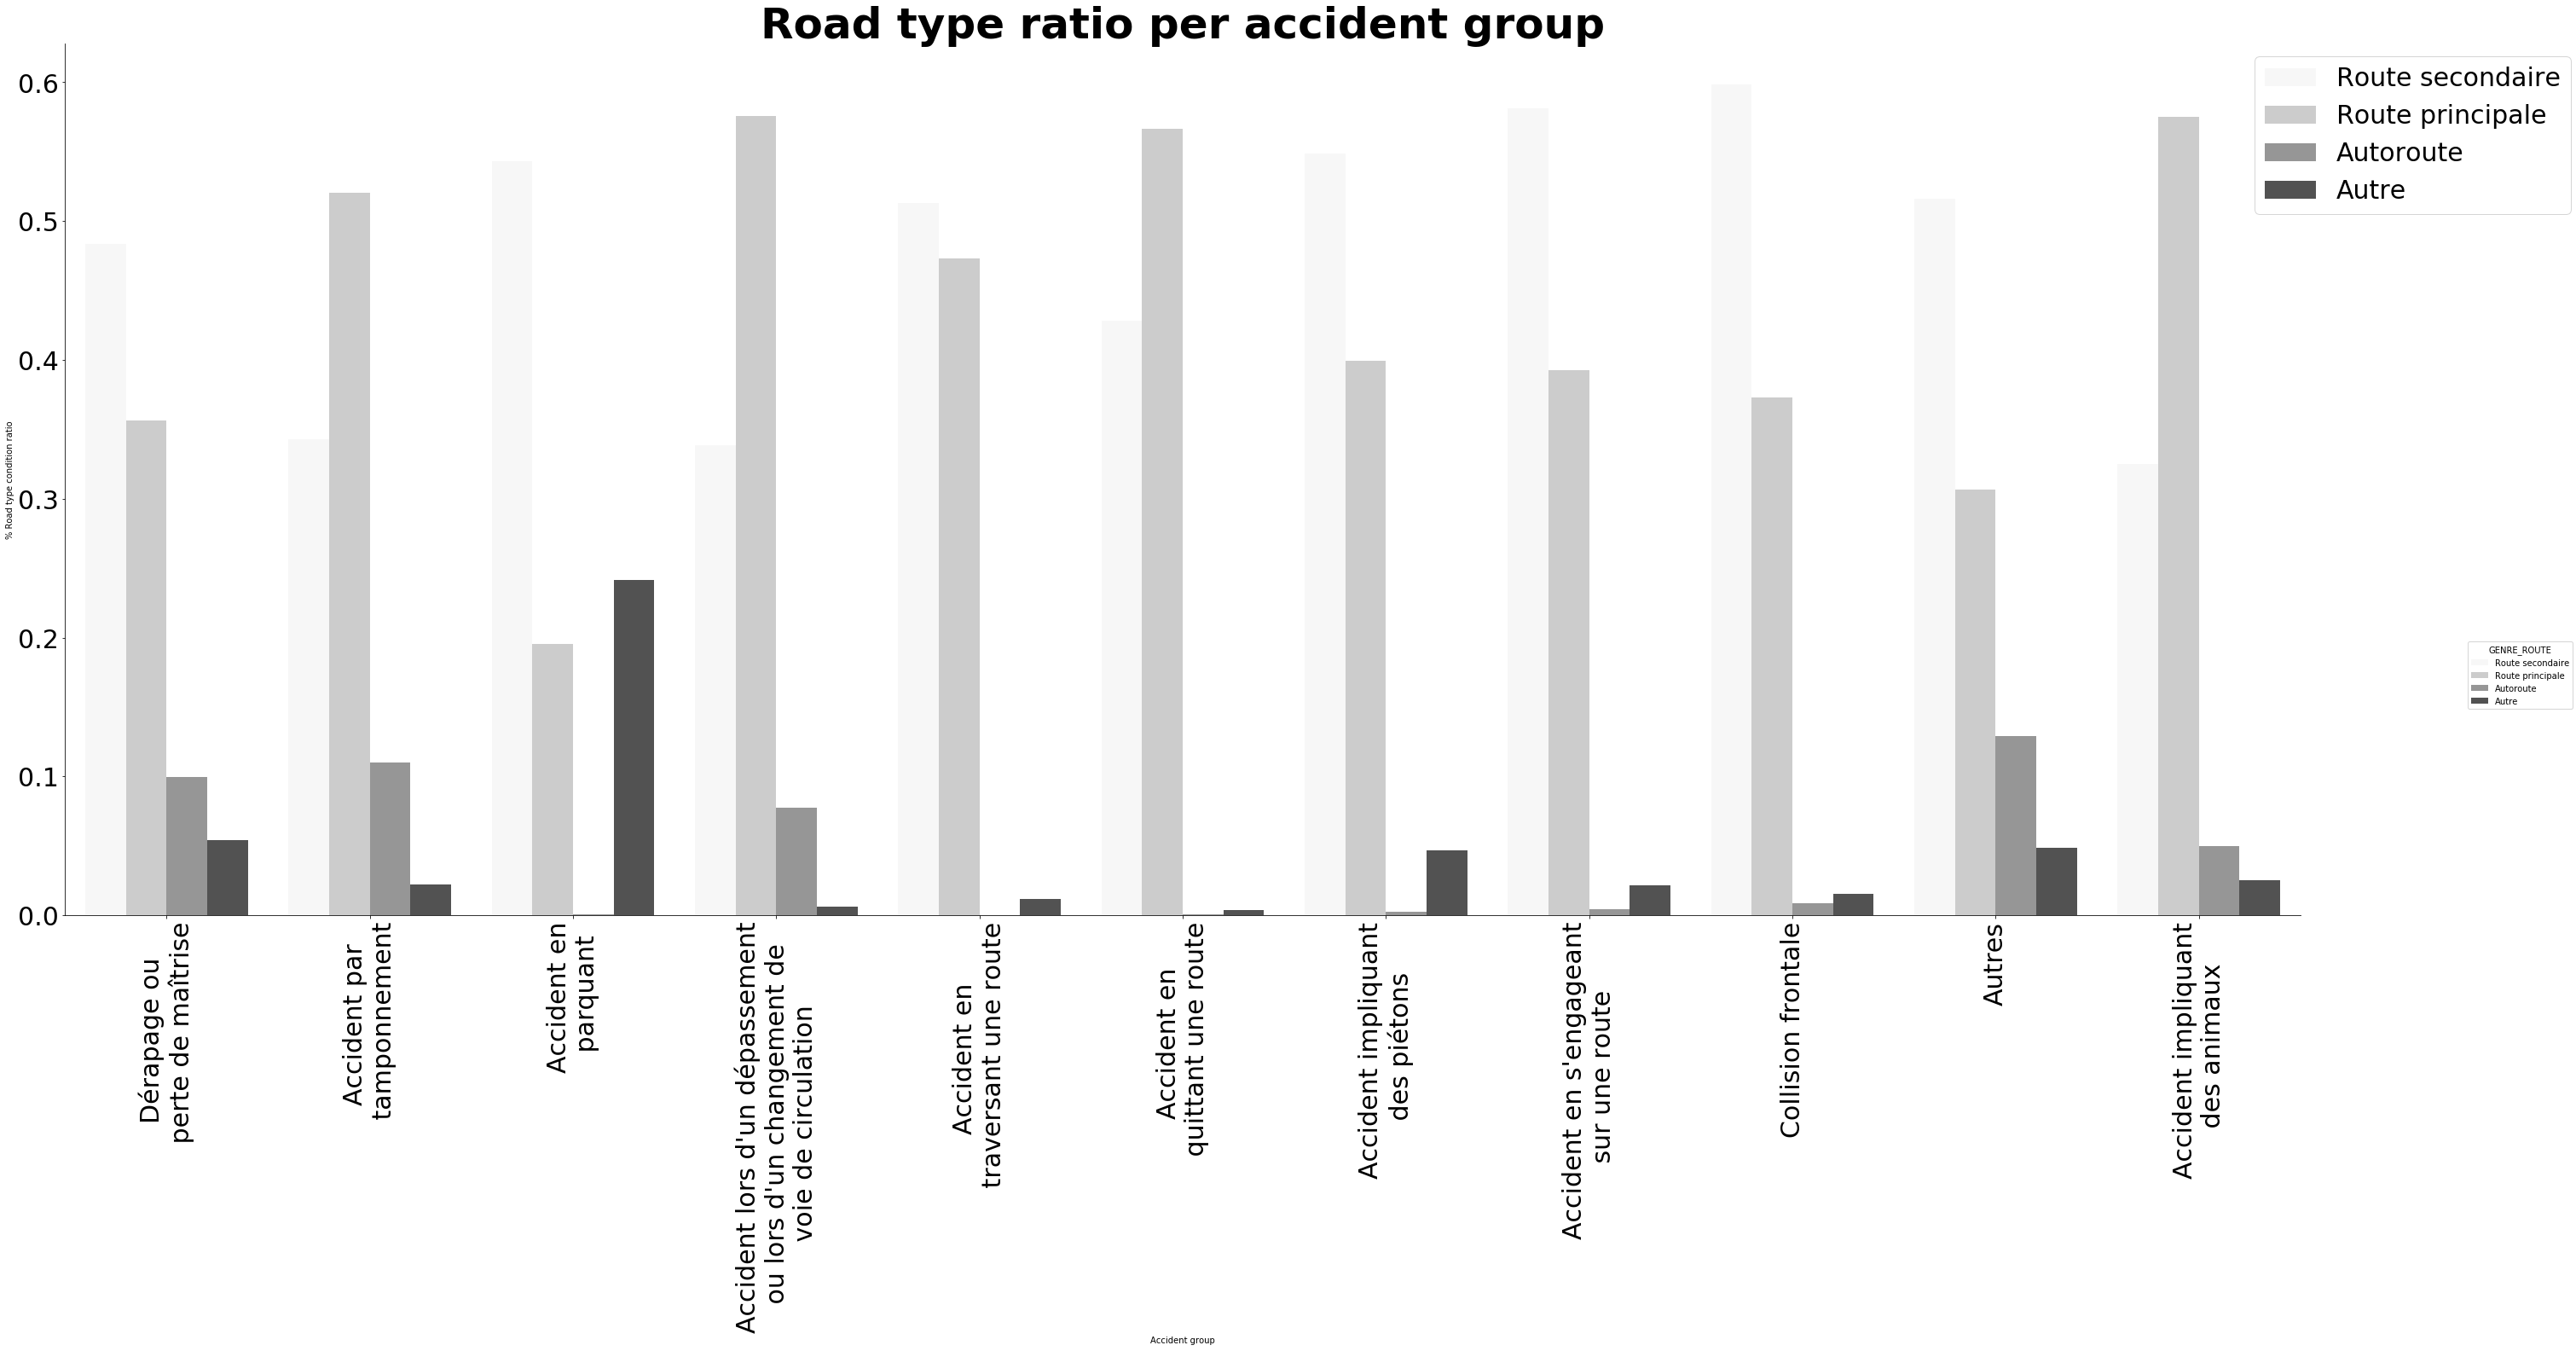

In [62]:
# Visualize it 
palette = ["#f7f7f7", "#cccccc", "#969696", "#525252"]
ax = sns.factorplot(data=road_pvt, x="GROUPE_ACCIDENT", y="YEAR",   
                    hue="GENRE_ROUTE", 
                    hue_order=['Route secondaire', 'Route principale', 'Autoroute', 'Autre'],
                    order=order_groupacc,
                    legend_out=True, orient='v',
                    size=15, aspect=2.5, kind="bar", palette=palette)

xticks_accident_group()
ax.set_yticklabels(fontsize=30)
ax.set_xticklabels(fontsize=30, rotation=90)
ax.set_axis_labels("Accident group","% Road type condition ratio")
plt.title('Road type ratio per accident group', fontsize=50).set_weight('bold')
plt.legend(loc='upper center', bbox_to_anchor=(1.05,1), fontsize=30)

**ADD OBSERVATIONS**

### 2.4.2 Accident group cross time

In this section we are going to investigate the relation between the accident group and the time. The following time features will be investigated:
1. HOUR
2. Day of the week
3. MONTH

#### 2.4.2.1  Accident group cross HOUR

In [63]:
pd.crosstab(acc_df.HOUR, acc_df.CONSEQUENCES, margins=False).style.background_gradient(cmap='summer_r')

CONSEQUENCES,Autres,Avec blessés graves,Avec blessés légers,Avec tués
HOUR,,,,
0,301,50,81,1
1,257,44,71,2
2,265,37,66,1
3,207,24,43,1
4,230,29,37,1
5,264,30,71,8
6,317,66,152,4
7,464,121,313,2
8,577,142,357,5


In [64]:
pd.crosstab(acc_df.GROUPE_ACCIDENT, acc_df.COMMUNE, margins=False).style.background_gradient(cmap='summer_r')

COMMUNE,Aire-la-Ville,Anières,Athenaz (Avusy),Avully,Bellevue,Bernex,Carouge GE,Cartigny,Chambésy,Chancy,Choulex,Chêne-Bourg,Collex,Cologny,Conches,Confignon,Corsier GE,Céligny,Genthod,Genève,Gy,Hermance,Jussy,La Croix-de-Rozon,La Plaine,Laconnex,Le Grand-Saconnex,Meinier,Meyrin,Onex,Perly,Petit-Lancy,Plan-les-Ouates,Presinge,Puplinge,Russin,Satigny,Soral,Thônex,Troinex,Vandoeuvres,Vernier,Versoix,Vessy,Vésenaz
GROUPE_ACCIDENT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Accident en parquant,5,5,1,10,21,33,161,4,13,4,1,68,5,29,52,11,3,1,7,1585,0,3,6,8,6,1,90,4,165,70,9,136,43,1,8,1,21,1,73,8,5,226,62,32,35
Accident en quittant une route,1,5,2,0,7,19,59,1,7,3,0,16,2,20,39,5,5,2,2,618,0,0,2,2,2,1,17,5,67,17,20,67,43,1,2,1,9,4,33,4,6,74,17,13,31
Accident en s'engageant sur une route,1,6,0,1,18,12,41,4,7,0,0,19,1,18,19,3,1,1,2,381,0,1,2,0,1,2,24,5,43,16,10,47,31,0,2,3,11,1,25,7,8,68,18,12,14
Accident en traversant une route,1,1,2,0,5,25,60,4,4,0,6,14,5,16,23,1,5,1,3,670,0,1,3,5,1,2,25,21,86,32,20,83,30,0,6,1,8,1,39,7,4,72,22,21,18
Accident impliquant des animaux,0,2,1,0,2,1,4,0,0,1,1,0,0,0,0,0,1,0,0,6,0,0,3,0,0,1,0,0,1,0,0,0,1,2,0,0,5,0,0,2,0,1,5,0,0
Accident impliquant des piétons,0,6,0,0,3,8,71,1,8,1,2,17,2,11,31,4,0,0,6,739,0,0,1,1,3,1,18,0,52,19,5,68,19,0,0,0,5,0,30,1,2,68,19,8,17
Accident lors d'un dépassement ou lors d'un changement de voie de circulation,2,1,0,0,29,20,81,0,7,2,3,9,1,40,37,29,3,0,7,1015,0,0,4,10,1,1,65,5,110,8,13,92,58,1,3,0,8,3,31,2,12,177,19,15,10
Accident par tamponnement,2,9,1,6,70,70,146,3,20,1,2,38,9,72,81,59,13,2,9,1638,0,1,6,10,1,0,95,4,190,41,20,221,99,2,10,2,14,1,76,3,14,400,88,30,36
Autres,0,0,0,0,5,4,4,0,1,0,0,1,0,2,4,0,0,0,1,57,0,1,0,0,0,0,6,0,1,0,1,9,5,0,0,1,1,1,9,0,0,6,1,2,1


In [65]:
# Count d'accidents par groupe d'accident et conditions lumneuses
features = ['GROUPE_ACCIDENT', 'HOUR', 'YEAR']
hour_pvt = acc_df[features].pivot_table(index=['GROUPE_ACCIDENT', 'HOUR'], 
                             aggfunc=len,
                            fill_value=0)
# Reset index
hour_pvt = hour_pvt.reset_index()

# Compute the percentage over the group_accident total accidents
for acc, acc_counts in zip(grouacc_valuecounts_id, grouacc_valuecounts):
    hour_pvt.YEAR[hour_pvt.GROUPE_ACCIDENT == acc] = hour_pvt.YEAR/acc_counts  

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


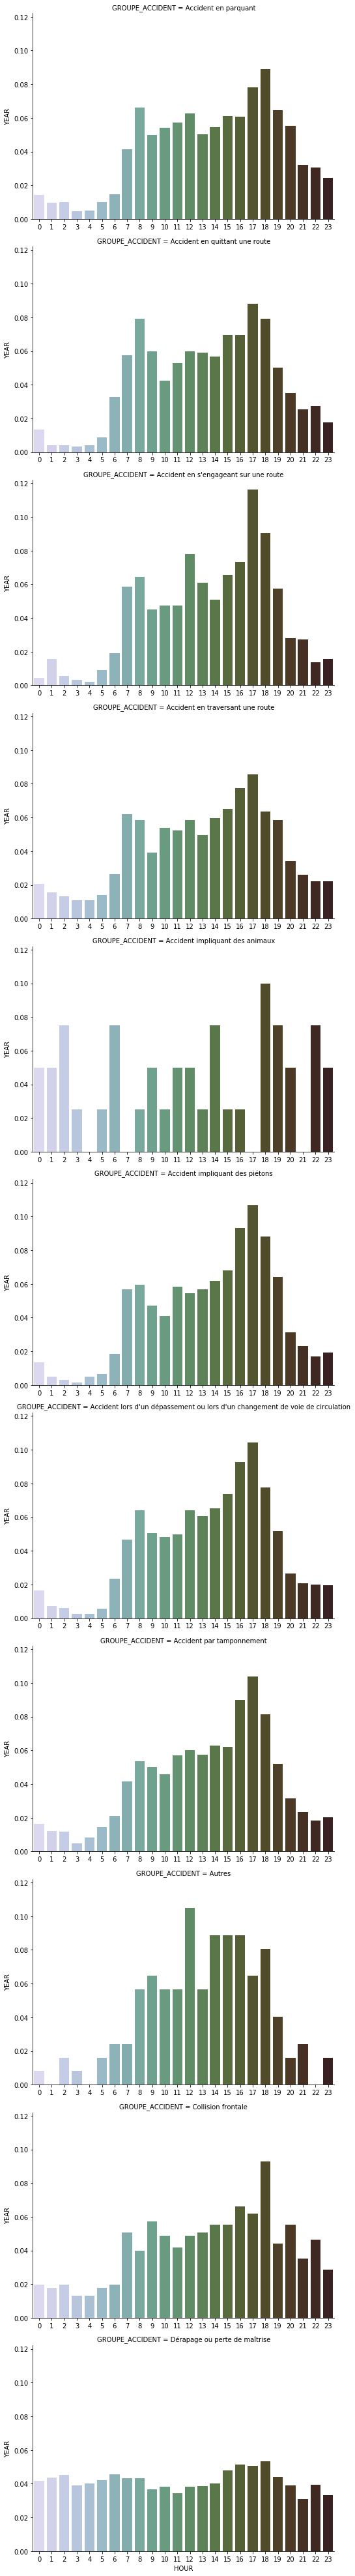

In [66]:
palette = sns.cubehelix_palette(24, start=.5, rot=1)
ax = sns.factorplot(data=hour_pvt, x="HOUR", y="YEAR",   
                    row="GROUPE_ACCIDENT", 
                    orient='v', label='big',
                    size=5, aspect=1.5, kind="bar", palette=palette)

#### 2.4.2.1  Accident group cross day of the week

In [67]:
# Count d'accidents par groupe d'accident et conditions lumneuses
features = ['GROUPE_ACCIDENT', 'JOUR', 'YEAR']
jour_pvt = acc_df[features].pivot_table(index=['GROUPE_ACCIDENT', 'JOUR'], 
                             aggfunc=len,
                            fill_value=0)
# Reset index
jour_pvt = jour_pvt.reset_index()

# Compute the percentage over the group_accident total accidents
for acc, acc_counts in zip(grouacc_valuecounts_id, grouacc_valuecounts):
    jour_pvt.YEAR[jour_pvt.GROUPE_ACCIDENT == acc] = jour_pvt.YEAR/acc_counts  

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [68]:
acc_df.JOUR.value_counts().index

Index(['Vendredi', 'Jeudi', 'Mardi', 'Mercredi', 'Samedi', 'Lundi',
       'Dimanche'],
      dtype='object')

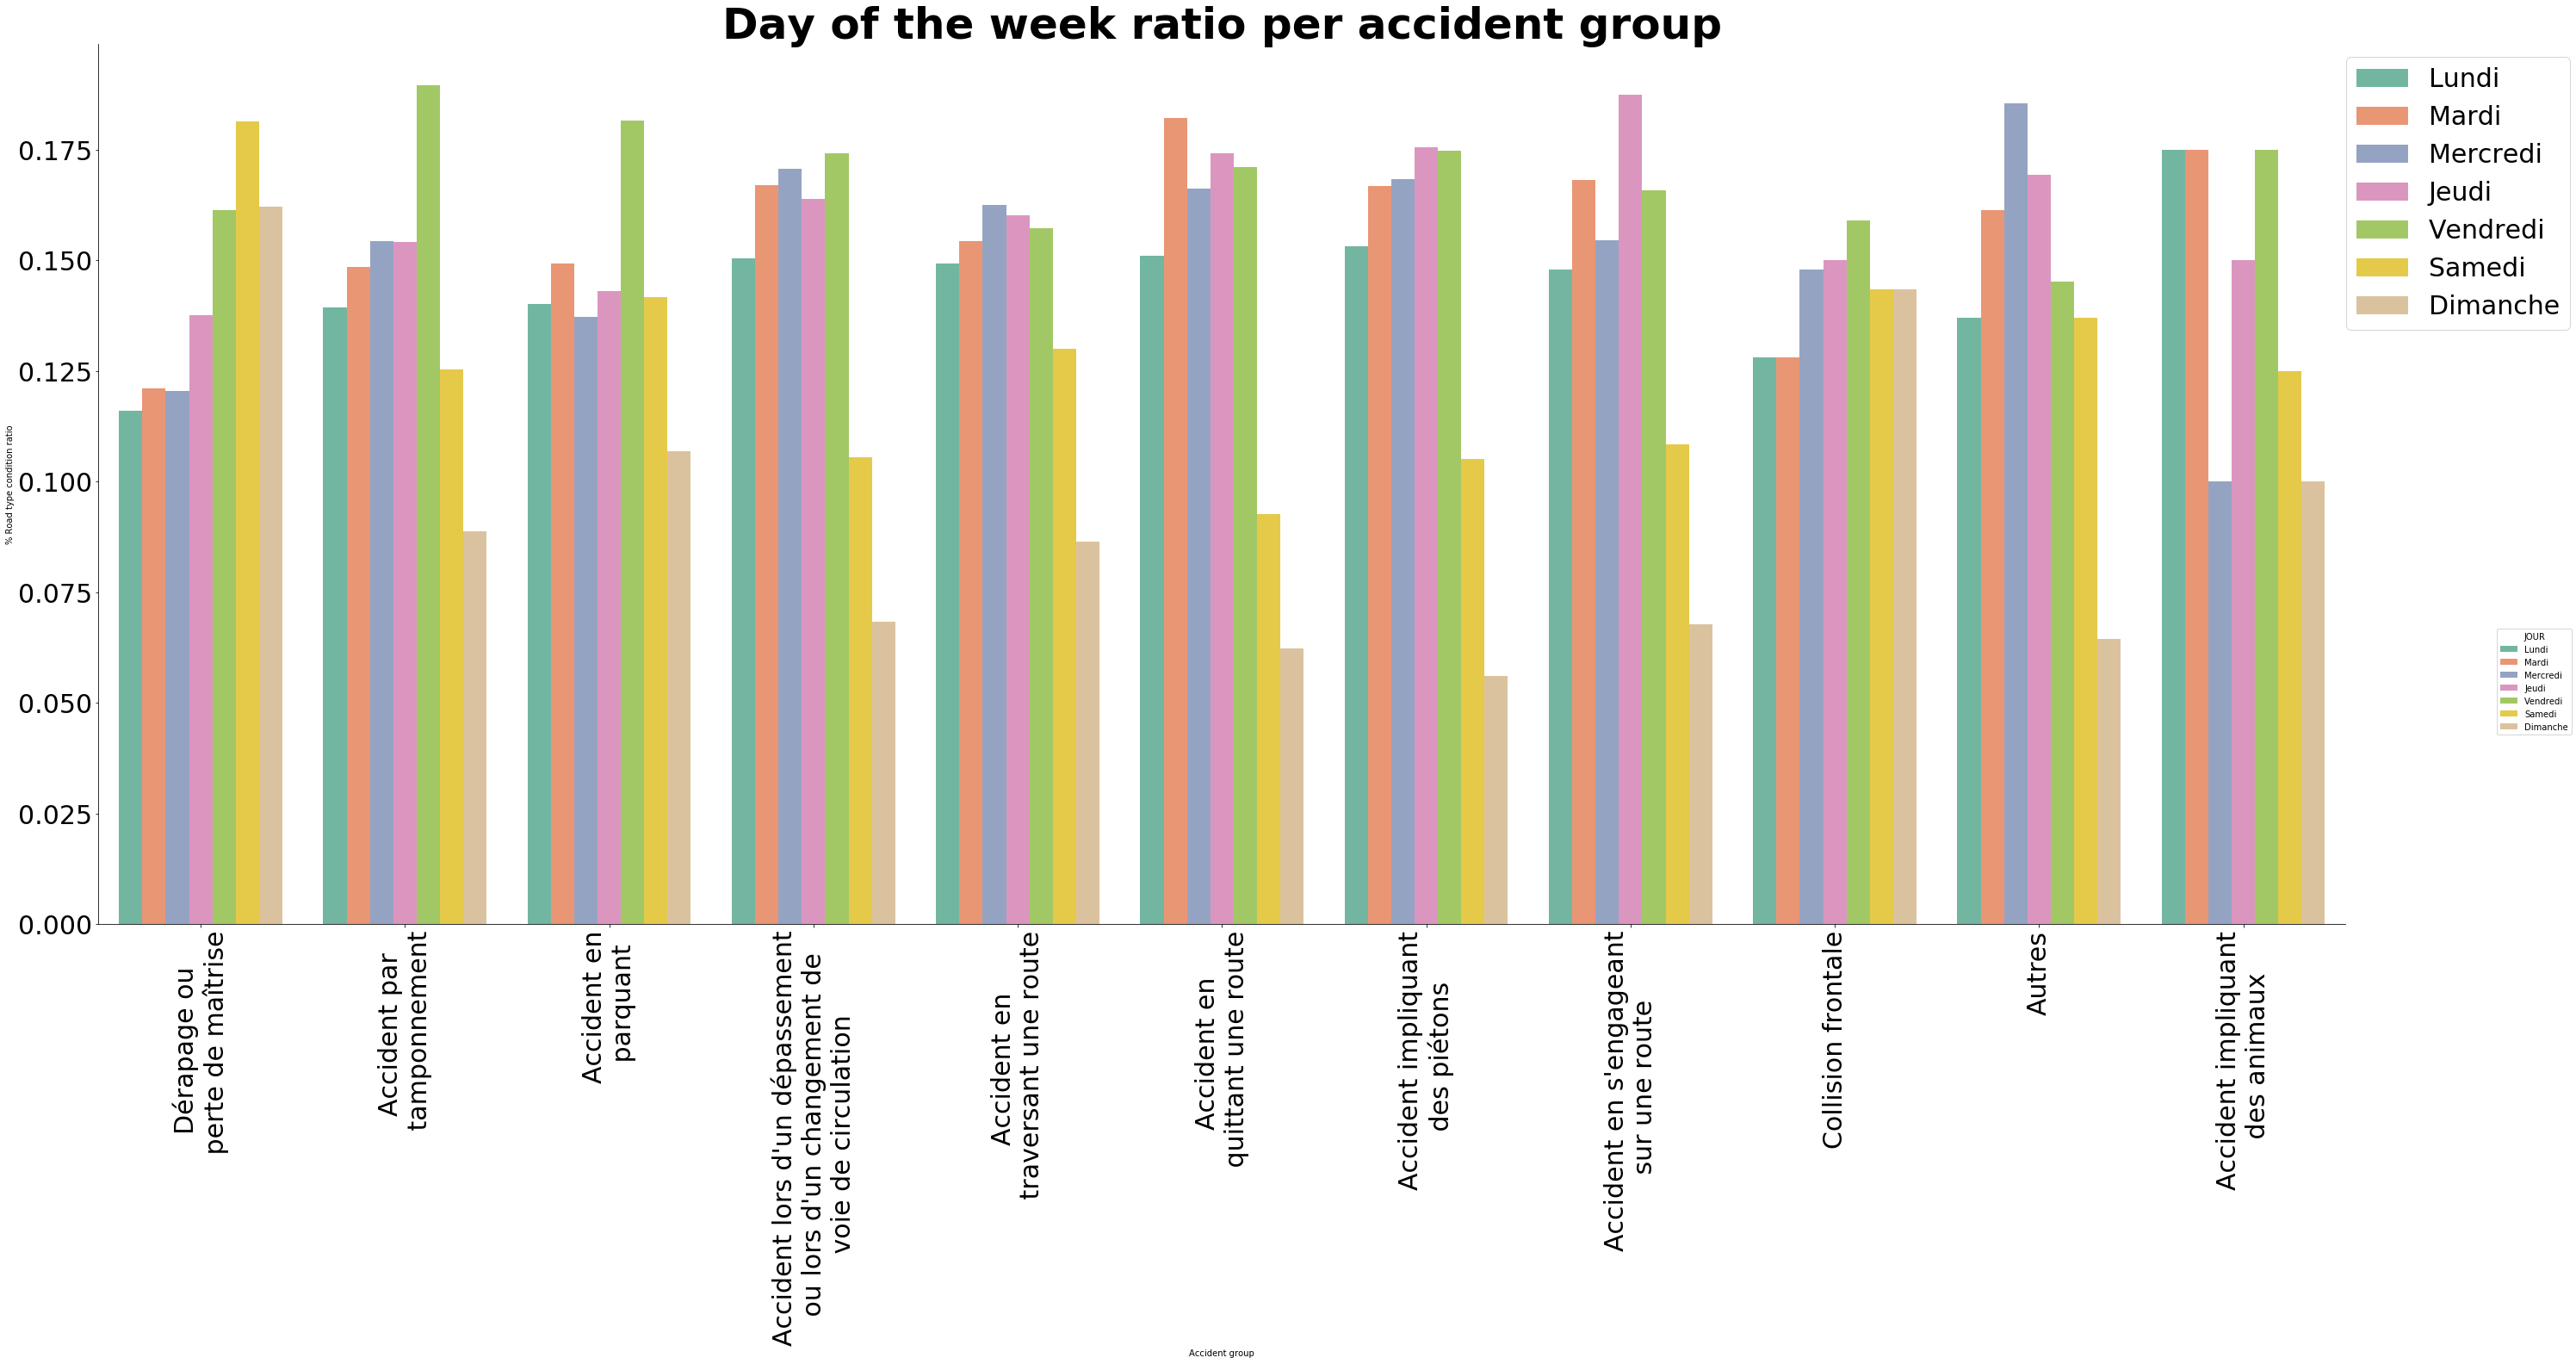

In [69]:
# Visualize it 
palette = "Set2"
ax = sns.factorplot(data=jour_pvt, x="GROUPE_ACCIDENT", y="YEAR",   
                    hue="JOUR", 
                    hue_order=['Lundi', 'Mardi', 'Mercredi', 'Jeudi','Vendredi', 'Samedi', 'Dimanche'],
                    order=order_groupacc,
                    legend_out=True, orient='v',
                    size=15, aspect=2.5, kind="bar", palette=palette)

xticks_accident_group()
ax.set_yticklabels(fontsize=30)
ax.set_xticklabels(fontsize=30, rotation=90)
ax.set_axis_labels("Accident group","% Road type condition ratio")
plt.title('Day of the week ratio per accident group', fontsize=50).set_weight('bold')
plt.legend(loc='upper center', bbox_to_anchor=(1.05,1), fontsize=30)

### 2.4.1 Cause
By visualizing and analysing the causes columns,we identified that it is used a '-' in order to separed the group of causes and subgroups. Let's create both features in our dataset:

In [70]:
# Create a new df to treat the causes column
causes = acc_df[['CAUSE', 'GROUPE_ACCIDENT']]
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
del causes['GROUPE_ACCIDENT']

# Split the causes into two columns, group and sugroup of causes
conflictive_txt = "(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)"
causes.CAUSE = causes.CAUSE.str.replace(conflictive_txt, "")
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
causes = causes.CAUSE.str.split(' - ', expand=True)
causes.rename(columns ={0: 'CAUSE_g', 1: 'CAUSE_sg'}, inplace=True)
acc_df = pd.concat([acc_df, causes], axis=1)
del acc_df['CAUSE']
acc_df.head(2)

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,DATE_,GROUPE_ACCIDENT,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,GENRE_ROUTE,...,HOUR,DayTime,SEASON,NB_MOTO,NB_BIKE,NB_TPubl,NB_ProfT,NB_LourdT,CAUSE_g,CAUSE_sg
0,2010-11-30,Dérapage ou perte de maîtrise,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,Route secondaire,...,21,Evening,Autumn,0.0,0.0,0.0,0.0,0.0,Inattention et distraction,Manque d'attention momentané
1,2010-12-08,Autres,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,Route secondaire,...,14,Afternoon,Winter,0.0,0.0,0.0,0.0,0.0,Utilisation inadéquate du véhicule,Stationnement sans précautions suffisantes


In [71]:
rel_feat =['Dérapage ou perte de maîtrise', 'Accident par tamponnement','Accident impliquant des piétons']
relevant_acc_df = acc_df[acc_df.GROUPE_ACCIDENT.isin(rel_feat)]
relevant_acc_df.CAUSE_g.value_counts().index
cause_rel_index = ['Inattention et distraction', 'Etat / intention du conducteur',
       'Autres mouvements dans la circulation', 'Cause inconnue', 'Vitesse',
       'Refus d\'accorder la priorité', 'Influence / comportement du piéton',
       'Utilisation inadéquate du véhicule', 'Dépassement (circulation)',
       'Circulation à droite / à gauche et présélectionnement']
relevant_acc_df = relevant_acc_df[relevant_acc_df.CAUSE_g.isin(cause_rel_index)]
relevant_acc_df
pd.crosstab(relevant_acc_df.CAUSE_g, relevant_acc_df.GROUPE_ACCIDENT, margins=False).style.background_gradient(cmap='summer_r')

GROUPE_ACCIDENT,Accident impliquant des piétons,Accident par tamponnement,Dérapage ou perte de maîtrise
CAUSE_g,,,
Autres mouvements dans la circulation,69,1375,438
Cause inconnue,64,204,545
Circulation à droite / à gauche et présélectionnement,6,19,71
Dépassement (circulation),13,33,51
Etat / intention du conducteur,20,367,1517
Inattention et distraction,106,1446,1438
Influence / comportement du piéton,475,0,25
Refus d'accorder la priorité,367,18,153
Utilisation inadéquate du véhicule,8,67,129


In [284]:
heat_data.index

Index(['Dimanche', 'Jeudi', 'Lundi', 'Mardi', 'Mercredi', 'Samedi',
       'Vendredi'],
      dtype='object', name='JOUR')

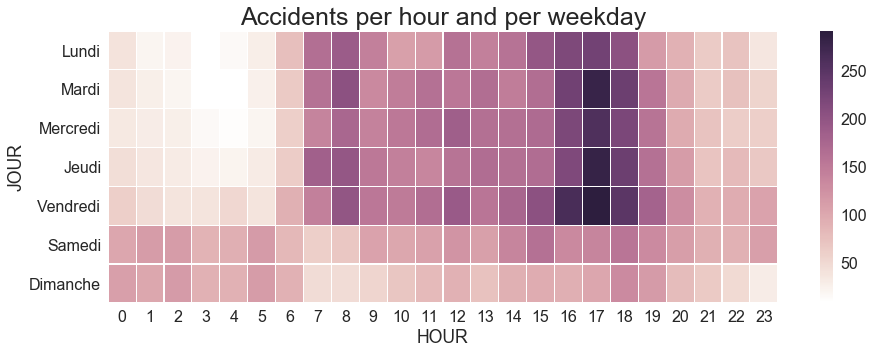

In [306]:

pieton = acc_df[acc_df.GROUPE_ACCIDENT=='Accident impliquant des piétons']
tamp = acc_df[acc_df.GROUPE_ACCIDENT=='Accident par tamponnement']
drift = acc_df[acc_df.GROUPE_ACCIDENT=='Dérapage ou perte de maîtrise']
sns.set(font_scale=1.6)
# General
heat_data=acc_df.groupby(['JOUR', 'HOUR'])['YEAR'].count().to_frame().unstack()
heat_data.columns = heat_data.columns.droplevel()
heat_data = heat_data.reindex(index = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'])
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.figure(figsize=(15,5))
sns.heatmap(heat_data,linewidths=.2,cmap=cmap)
plt.title('Accidents per hour and per weekday', fontsize=25)
pylab.savefig('Images/dayhour_all.png')

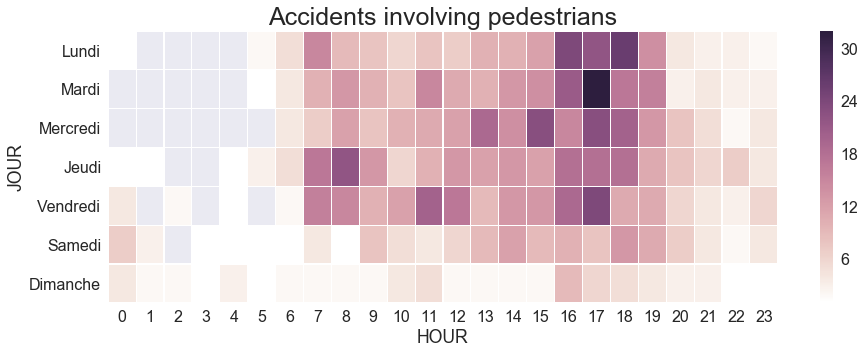

In [302]:
# pieton
heat_data=pieton.groupby(['JOUR', 'HOUR'])['YEAR'].count().to_frame().unstack()
heat_data.columns = heat_data.columns.droplevel()
heat_data = heat_data.reindex(index = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'])
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.figure(figsize=(15,5))
sns.heatmap(heat_data,linewidths=.2,cmap=cmap)
plt.title('Accidents involving pedestrians', fontsize=25)
pylab.savefig('Images/dayhour_pedestrians.png')

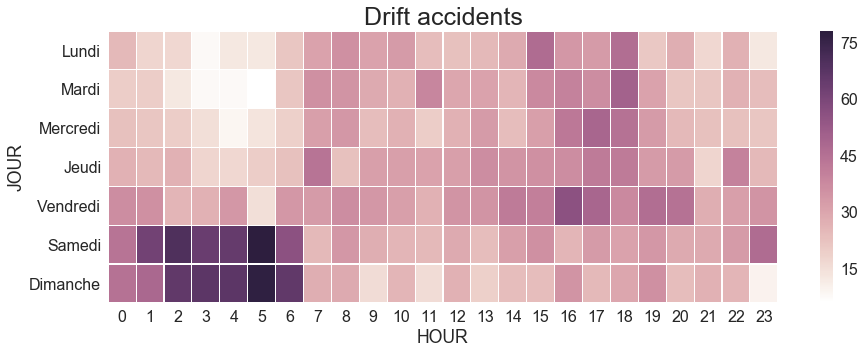

In [303]:
# drift
heat_data=drift.groupby(['JOUR', 'HOUR'])['YEAR'].count().to_frame().unstack()
heat_data.columns = heat_data.columns.droplevel()
heat_data = heat_data.reindex(index = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'])
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.figure(figsize=(15,5))
sns.heatmap(heat_data,linewidths=.2,cmap=cmap)
plt.title('Drift accidents', fontsize=25)
pylab.savefig('Images/dayhour_drift.png')

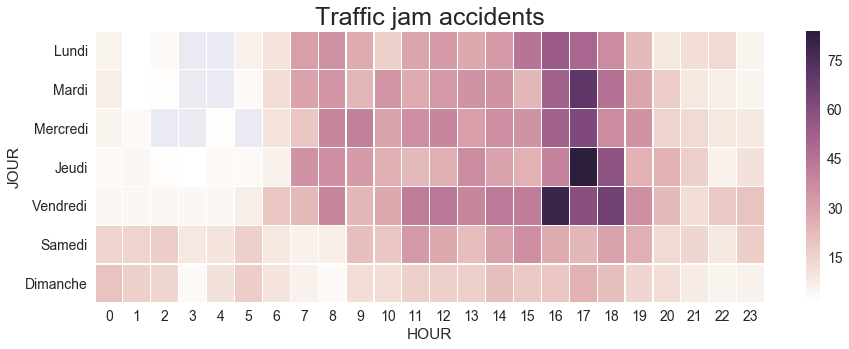

In [304]:
# tamp
sns.set(font_scale=1.4)
heat_data=tamp.groupby(['JOUR', 'HOUR'])['YEAR'].count().to_frame().unstack()
heat_data.columns = heat_data.columns.droplevel()
heat_data = heat_data.reindex(index = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'])
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.figure(figsize=(15,5))
sns.heatmap(heat_data,linewidths=.2,cmap=cmap)
plt.title('Traffic jam accidents', fontsize=25)
pylab.savefig('Images/dayhour_traffic.png')

In [74]:
from folium.plugins import HeatMap


# Locate children accident in the map
Geneve_coord = [46.2004013, 6.1531163]
m = folium.Map(location=Geneve_coord,
               tiles='stamentoner',
               zoom_start=10)

#hm_wide =zip(speed_rel_acc_df.COOR_Y,speed_rel_acc_df.COOR_X)
m.add_child(HeatMap(hm_wide,min_opacity=0.2,
                     radius=17, blur=15,
                     max_zoom=1))

cause_speed = ['Vitesse']
speed_rel_acc_df = relevant_acc_df[relevant_acc_df.CAUSE_g.isin(cause_speed)].reset_index()

# plot heatmap

#m

NameError: name 'hm_wide' is not defined

In [75]:
pd.crosstab(relevant_acc_df.CAUSE_sg[relevant_acc_df.CAUSE_sg.isin(['Excès de fatigue, endormissement (y compris endormissement passager)', 
                                                                   'Influence de l\'alcool',
                                                                  'Manque d\'attention momentané'])],
            relevant_acc_df.CAUSE_g[relevant_acc_df.CAUSE_g.isin(['Etat / intention du conducteur', 
                                                                  'Inattention et distraction'])], 
            margins=False).style.background_gradient(cmap='summer_r')

CAUSE_g,Etat / intention du conducteur,Inattention et distraction
CAUSE_sg,,
"Excès de fatigue, endormissement (y compris endormissement passager)",150,0
Influence de l'alcool,1628,0
Manque d'attention momentané,0,2830


In [76]:
pd.crosstab(relevant_acc_df.CAUSE_sg,
            relevant_acc_df.CAUSE_g[relevant_acc_df.CAUSE_g.isin(['Vitesse'])],
            margins=False).style.background_gradient(cmap='summer_r')


CAUSE_g,Vitesse
CAUSE_sg,
Autre attitude fautive ayant trait à la vitesse,4
"Inadaptée au tracé de la route (virage serré, proximité d'un débouché, etc.)",447
"Inadaptée aux conditions de la route (mouillée, verglacée, gravillon, feuilles, etc.)",240
"Inadaptée aux conditions de visibilité (réduite en raison du temps, de la luminosité)",25
Inadaptée aux conditions du trafic,31
"Poursuite, course",33
Supérieure à la vitesse maximale autorisée ou signalée (chauffard),16


In [78]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

acc_alchool = acc_df[acc_df.CAUSE_sg=='Influence de l\'alcool']
pd.crosstab(acc_alchool.YEAR, acc_alchool.CONSEQUENCES, margins=False).style.background_gradient(cmap='summer_r')


CONSEQUENCES,Autres,Avec blessés graves,Avec blessés légers,Avec tués
YEAR,,,,
2010,96,23,34,0
2011,126,22,45,0
2012,121,40,47,2
2013,175,37,57,0
2014,198,46,67,1
2015,194,39,77,2
2016,242,44,63,1


In [262]:
pd.crosstab(acc_alchool.HOUR, acc_alchool.JOUR, margins=False).style.background_gradient(cmap='summer_r')

JOUR,Dimanche,Jeudi,Lundi,Mardi,Mercredi,Samedi,Vendredi
HOUR,,,,,,,
0,32,17,18,8,14,30,25
1,37,16,8,12,9,37,22
2,47,15,7,2,12,51,17
3,27,5,2,5,6,42,16
4,43,13,7,2,7,47,23
5,46,10,4,3,6,55,12
6,44,4,6,1,2,27,16
7,18,7,0,3,0,14,6
8,10,3,1,3,1,11,1


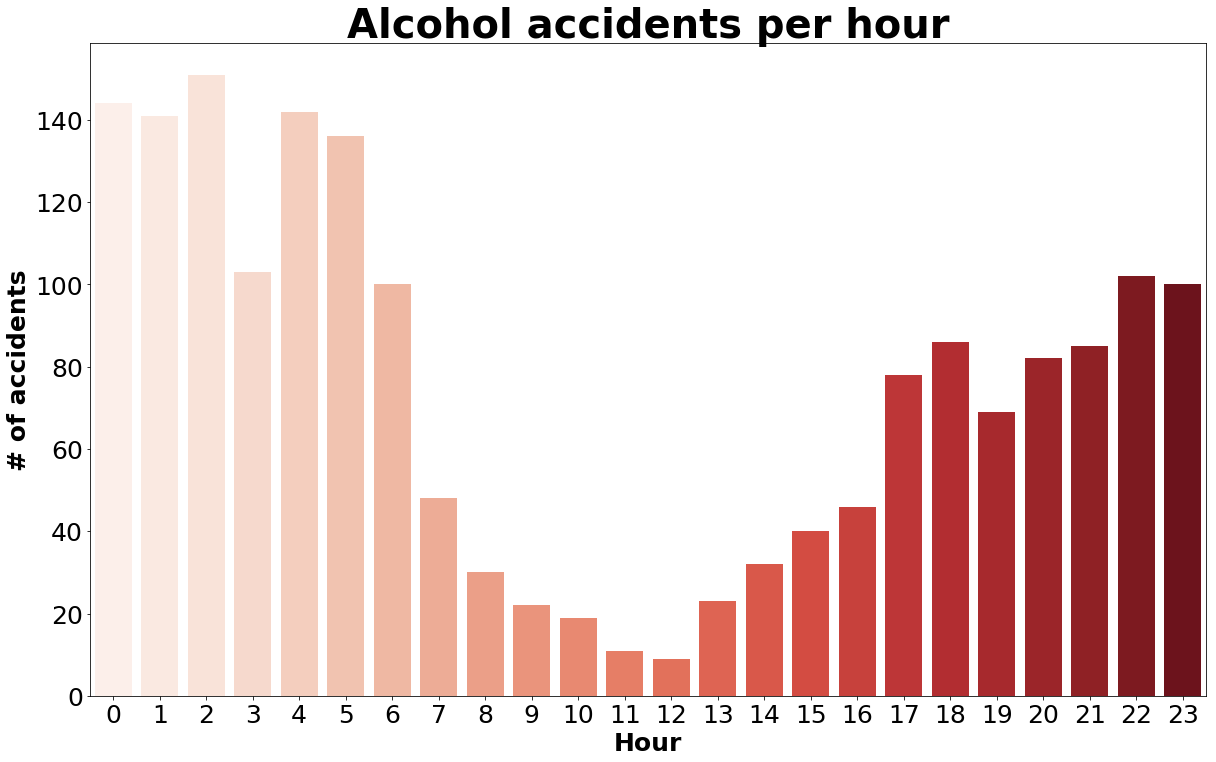

In [258]:
# Compute number of accidents per day of the week and per year
# Accidents per year
fig = plt.figure(figsize=(20,12))

# Visualize accidents per Year
acc_Hour = acc_alchool.HOUR.value_counts(ascending=True, sort=False)
ax4 = sns.barplot(x=acc_Hour.index, 
                 y=acc_Hour, 
                 palette='Reds')
#value_barplot_label(ax4)
plt.title("Alcohol accidents per hour", fontsize=40).set_weight('bold')
tick_format(ax4, 4)
ax4.set_ylabel('# of accidents', fontsize=25).set_weight('bold')
ax4.set_xlabel('Hour', fontsize=25).set_weight('bold')

pylab.savefig('Images/acc_alc_hour.png')

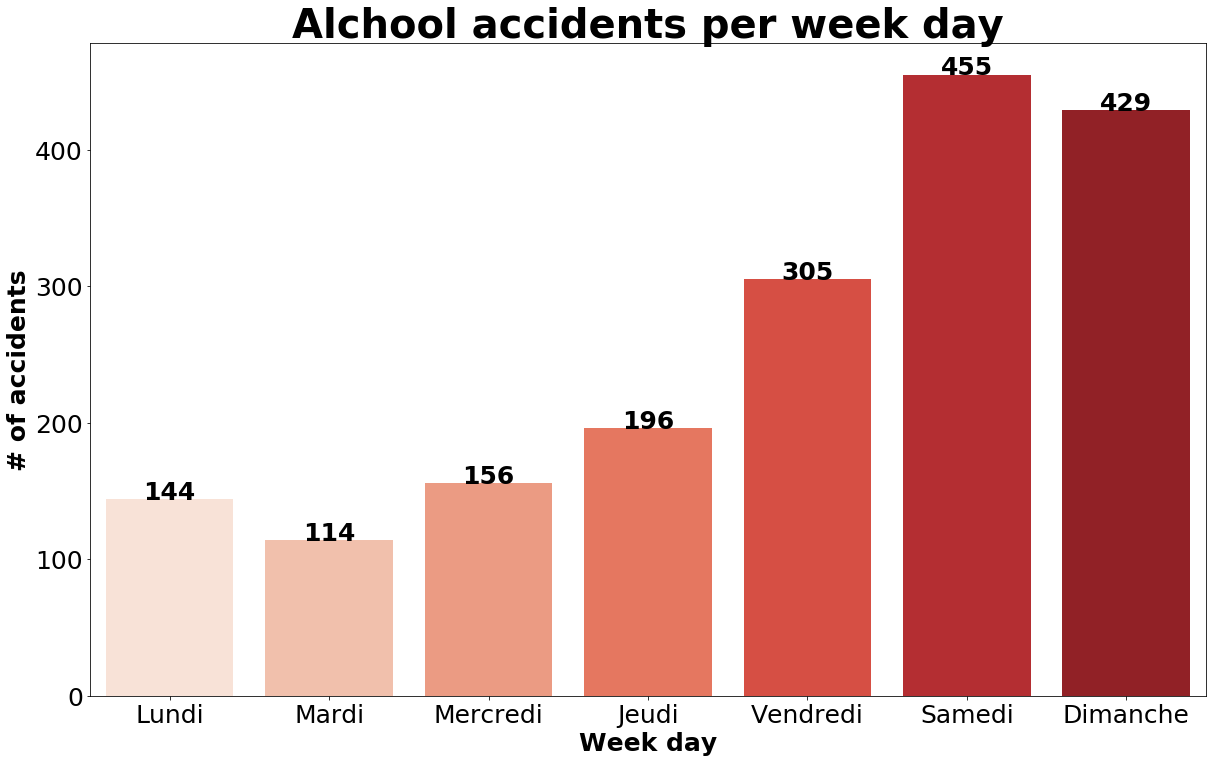

In [259]:
# Accidents per year
fig = plt.figure(figsize=(20,12))

# Visualize accidents per Year
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_alchool.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds')
value_barplot_label(ax4)
plt.title("Alchool accidents per week day", fontsize=40).set_weight('bold')
tick_format(ax4, 4)
ax4.set_ylabel('# of accidents', fontsize=25).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=25).set_weight('bold')

pylab.savefig('Images/acc_alc_weekday.png')

In [261]:
acc_alchool.groupby(['YEAR', 'NB_MOTO'])['YEAR'].count().to_frame().fillna(0).unstack()

YEAR           
NB_MOTO    0.0   1.0  2.0
YEAR                     
2010     131.0  22.0  NaN
2011     170.0  22.0  1.0
2012     175.0  35.0  NaN
2013     240.0  29.0  NaN
2014     280.0  32.0  NaN
2015     301.0  11.0  NaN
2016     332.0  17.0  1.0

In [202]:
data = acc_df.groupby(['YEAR', 'CONSEQUENCES'])['YEAR'].count().to_frame().fillna(0).unstack()
features = ['Autres','Avec blessés légers','Avec blessés graves','Avec tués']
data.columns = data.columns.droplevel()
data = data[features]
data

CONSEQUENCES,Autres,Avec blessés légers,Avec blessés graves,Avec tués
YEAR,,,,
2010,1441,586,313,14
2011,999,632,271,15
2012,1152,688,323,12
2013,1722,809,362,10
2014,1780,927,362,11
2015,2156,928,327,9
2016,2212,838,321,11


In [185]:
data.loc[2010].values

array([1441,  586,  313,   14])

In [309]:
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.embed import components

output_file("num_consequences.html")

data = acc_df.groupby(['YEAR', 'CONSEQUENCES'])['YEAR'].count().to_frame().fillna(0).unstack()
features = ['Autres','Avec blessés légers','Avec blessés graves','Avec tués']
data.columns = data.columns.droplevel()
data = data[features]

consequences = ['Autres', 'Avec blessés légers', 'Avec blessés graves', 'Avec tués']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
colors = ["#c9d9d3", "#718dbf", "#e84d60","#af8dc3"]

data = {'years' : years,
        'Autres'   : data['Autres'].values,
        'Avec blessés légers'   : data['Avec blessés légers'].values,
        'Avec blessés graves'   : data['Avec blessés graves'].values,
        'Avec tués'   : data['Avec tués'].values}

source = ColumnDataSource(data=data)

p = figure(x_range=years, plot_height=350, title="Number of accidents by consequence",
           toolbar_location=None, tools="")

p.vbar_stack(consequences, x='years', width=0.9, color=colors, source=source, legend=[value(x) for x in consequences])

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "bottom_center"
p.legend.orientation = "horizontal"
p.legend.click_policy="hide"
script, div = components(p)
with open("xav_script.html", "w") as att_file:
    att_file.write(script)
with open("xav_div.html", "w") as att_file:
    att_file.write(div)    
show(p)

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='84e936e0-f536-484d-94fb-62c2e70d5c3f', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='91d3e37e-6af4-4d23-a154-643bef5fec8f', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='a5f9e953-e94e-4577-95e4-e0bb3e0fe5d8', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='d50feb8e-349c-4f51-942d-b3308882f09b', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='0d722386-db98-4fc3-b8fb-8be62ac97c1c', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='23f85661-8eb9-4b30-81a2-6af1511b9251', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: years [renderer: GlyphRenderer(id='58452e23-1f5c-4e

In [229]:
acc_df.columns

Index(['DATE_', 'GROUPE_ACCIDENT', 'COMMUNE', 'CONDITIONS_LUMINEUSES',
       'CONDITIONS_METEO', 'CONSEQUENCES', 'COOR_X', 'COOR_Y', 'ETAT_ROUTE',
       'GENRE_ROUTE', 'JOUR', 'LOCALITE', 'NB_ENFANTS_IMPLIQUES',
       'NB_ENFANTS_ECOLE', 'NB_BLESSES_LEGERS', 'NB_BLESSES_GRAVES', 'NB_TUES',
       'NB_PIETONS', 'NB_BICYCLETTES', 'NB_VAE_25', 'NB_VAE_45',
       'NB_CYCLOMOTEURS', 'NB_MOTOS_50', 'NB_MOTOS_125', 'NB_MOTOS_11KW',
       'NB_VOITURES_TOURISME', 'NB_VOITURES_LIVRAISON', 'NB_CAMIONS', 'NB_BUS',
       'NB_TRAM', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'DayTime', 'SEASON',
       'NB_MOTO', 'NB_BIKE', 'NB_TPubl', 'NB_ProfT', 'NB_LourdT', 'CAUSE_g',
       'CAUSE_sg'],
      dtype='object')

In [ ]:
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

output_file("num_consequences.html")

data = acc_df.groupby(['YEAR', 'CONSEQUENCES'])['YEAR'].count().to_frame().fillna(0).unstack()
features = ['Autres','Avec blessés légers','Avec blessés graves','Avec tués']
data.columns = data.columns.droplevel()
data = data[features]

consequences = ['Autres', 'Avec blessés légers', 'Avec blessés graves', 'Avec tués']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
colors = ["#c9d9d3", "#718dbf", "#e84d60","#af8dc3"]

data = {'years' : years,
        'Autres'   : data['Autres'].values,
        'Avec blessés légers'   : data['Avec blessés légers'].values,
        'Avec blessés graves'   : data['Avec blessés graves'].values,
        'Avec tués'   : data['Avec tués'].values}

source = ColumnDataSource(data=data)

p = figure(x_range=years, plot_height=350, title="Number of accidents by consequence",
           toolbar_location=None, tools="")

p.vbar_stack(consequences, x='years', width=0.9, color=colors, source=source, legend=[value(x) for x in consequences])

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "bottom_center"
p.legend.orientation = "horizontal"
p.legend.click_policy="hide"

show(p)

In [ ]:
pd.crosstab(relevant_acc_df.CAUSE_sg,
            relevant_acc_df.CAUSE_g[relevant_acc_df.CAUSE_g.isin(['Influence / comportement du piéton'])], 
            margins=False).style.background_gradient(cmap='summer_r')

In [ ]:
# Visualize main causes
plt.figure(figsize=(12,8))
ax = sns.countplot(acc_df['CAUSE_g'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

`Refuse to give priority` is a major cause. Let's investigate it:

In [ ]:
# Create a new dataframe for this cause
nopriority_df = acc_df[acc_df.CAUSE_g == 'Refus d\'accorder la priorité']
nopriority_df.reset_index(drop=True, inplace=True)
nopriority_df.head(2)

Let's plot the **SUBCAUSES** for this important category of accidents:

In [ ]:
# Visualize the accident group
plt.figure(figsize=(15,10))
subcauses_accidents = nopriority_df['CAUSE_sg'].value_counts()
ax = sns.barplot(x=subcauses_accidents, 
                 y=subcauses_accidents.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(subcauses_accidents.index)))
plt.title("Accident Subcauses non priority", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Accident subcause', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')


We see that there are a lot of subcauses: let's keep only the "important" ones i.e. the ones that have at least 100 accidents

In [ ]:
# Keep subcauses with at least 100 accidents
important_subcauses = list(nopriority_df['CAUSE_sg'].value_counts()[nopriority_df['CAUSE_sg'].value_counts()>100].index)
important_subcauses

Let's keep only the major subcauses on accidents for nopriority_df

In [ ]:
nopriority_df = nopriority_df[[row in important_subcauses for row in nopriority_df['CAUSE_sg'] ]].reset_index(drop=True)

A further analysis on the the "**Carrefour_DB_expanalysis.ipynb**"

## 2.5 Accident seriousness

In this section, the seriousness of the accidents will be investigated.

The features related to the accident seriousness are the following:
- `CONSEQUENCES`
- `NB_BLESSES_LEGERS`
- `NB_BLESSES_GRAVES`
- `NB_TUES`
- `NB_ENFANTS_IMPLIQUES`
- `NB_ENFANTS_ECOLE`
- `NB_PIETONS`


In [ ]:
# Observe the proportion of each consequence
acc_df.CONSEQUENCES.value_counts()

It can be observed that less than a half of accidents are with injured or death people. In addition, the death accidents represent 82 out of 19'000 accident during 6 years.

In [ ]:
# Observe the distribution of slight injured in an accident
acc_df.NB_BLESSES_LEGERS.value_counts()

In [ ]:
# Observe the distribution of grave injured in an accident
acc_df.NB_BLESSES_GRAVES.value_counts()

In [37]:
# Observe the distribution of number of deaths in an accident
acc_df.NB_TUES.value_counts()

0.0    19149
1.0       81
2.0        1
Name: NB_TUES, dtype: int64

In [38]:
# Observe the distribution of children involved
acc_df.NB_ENFANTS_IMPLIQUES.value_counts()

0.0     18637
1.0       491
2.0        83
3.0        16
4.0         3
13.0        1
Name: NB_ENFANTS_IMPLIQUES, dtype: int64

In [39]:
# Observe the distribution of school schildren involved
acc_df.NB_ENFANTS_ECOLE.value_counts()

0.0     19170
1.0        56
2.0         3
11.0        1
3.0         1
Name: NB_ENFANTS_ECOLE, dtype: int64

In [40]:
# Observe the distribution of grave injured
acc_df.NB_PIETONS.value_counts()

0.0    17878
1.0     1286
2.0       57
3.0        9
6.0        1
Name: NB_PIETONS, dtype: int64

In [41]:
# Assemble all the seriouness features in a sole dataframe
seriousness_features = ['CONSEQUENCES', 'NB_BLESSES_LEGERS', 'NB_BLESSES_GRAVES', 'NB_TUES', 
                        'NB_ENFANTS_IMPLIQUES', 'NB_ENFANTS_ECOLE', 'NB_PIETONS']

seriousness = acc_df[seriousness_features]
seriousness.head(2)

,CONSEQUENCES,NB_BLESSES_LEGERS,NB_BLESSES_GRAVES,NB_TUES,NB_ENFANTS_IMPLIQUES,NB_ENFANTS_ECOLE,NB_PIETONS
0,Avec blessés légers,1.0,0.0,0.0,0.0,0.0,1.0
1,Autres,0.0,0.0,0.0,0.0,0.0,0.0


Let's investigate if there exists any correlation between the consequence type and the number of children /school children / pedestrian involved:

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


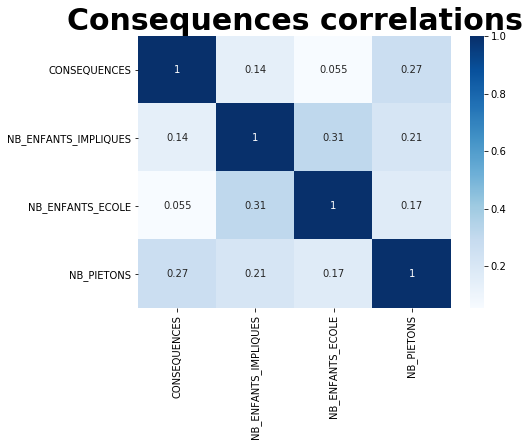

In [42]:
# Compute correltion between the following features
consequences_features = ['CONSEQUENCES','NB_ENFANTS_IMPLIQUES', 'NB_ENFANTS_ECOLE', 'NB_PIETONS']
conseq_corr = seriousness[consequences_features]

# Encode features
for feature in consequences_features:
    le = LabelEncoder()
    le = le.fit(conseq_corr[feature])
    conseq_corr[feature] = le.transform(conseq_corr[feature])

# Compute and visualize correlations
fig = plt.figure(figsize=(7,5))
plt.title('Consequences correlations', fontsize=30).set_weight('bold')
ax = sns.heatmap(conseq_corr.corr(), cmap="Blues", annot=True)

In [43]:
acc_df.head(5)

,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,...,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,YEAR,MONTH,DAY,HOUR,DayTime,SEASON
0,2010-11-30,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,...,0.0,0.0,0.0,0.0,2010,11,30,21,Evening,Autumn
1,2010-12-08,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,...,0.0,0.0,0.0,0.0,2010,12,8,14,Afternoon,Winter
2,2010-12-02,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,Enneigée,...,0.0,0.0,0.0,0.0,2010,12,2,10,Morning,Winter
3,2010-10-16,Collision frontale,Vitesse - Inadaptée au tracé de la route (vira...,Cologny,Nuit,Couvert,Avec blessés graves,6.180094,46.208173,Humide,...,0.0,0.0,0.0,0.0,2010,10,16,18,Evening,Autumn
4,2010-09-17,Accident par tamponnement,Inattention et distraction - Manque d'attentio...,Conches,Nuit,Pluie,Autres,6.174721,46.199584,Mouillée,...,0.0,0.0,0.0,0.0,2010,9,17,3,Night,Autumn


In [44]:
acc_df.columns

Index(['DATE_', 'GROUPE_ACCIDENT', 'CAUSE', 'COMMUNE', 'CONDITIONS_LUMINEUSES',
       'CONDITIONS_METEO', 'CONSEQUENCES', 'COOR_X', 'COOR_Y', 'ETAT_ROUTE',
       'GENRE_ROUTE', 'JOUR', 'LOCALITE', 'NB_ENFANTS_IMPLIQUES',
       'NB_ENFANTS_ECOLE', 'NB_BLESSES_LEGERS', 'NB_BLESSES_GRAVES', 'NB_TUES',
       'NB_PIETONS', 'NB_BICYCLETTES', 'NB_VAE_25', 'NB_VAE_45',
       'NB_CYCLOMOTEURS', 'NB_MOTOS_50', 'NB_MOTOS_125', 'NB_MOTOS_11KW',
       'NB_VOITURES_TOURISME', 'NB_VOITURES_LIVRAISON', 'NB_CAMIONS', 'NB_BUS',
       'NB_TRAM', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'DayTime', 'SEASON'],
      dtype='object')

In [45]:
# Create the pivot table
features = ['GROUPE_ACCIDENT', 'CONSEQUENCES', 'YEAR']
consequences_pvt =acc_df[features].pivot_table(index=['GROUPE_ACCIDENT', 'CONSEQUENCES'], 
                                                aggfunc=len,
                                                fill_value=0)
# Reset index
consequences_pvt = consequences_pvt.reset_index()

# Count the number of accidents per accident group
grouacc_valuecounts = acc_df.GROUPE_ACCIDENT.value_counts()
grouacc_valuecounts_id = acc_df.GROUPE_ACCIDENT.value_counts().index

# Compute the percentage over the group_accident total accidents
for acc, acc_counts in zip(grouacc_valuecounts_id, grouacc_valuecounts):
    consequences_pvt.YEAR[consequences_pvt.GROUPE_ACCIDENT == acc] = consequences_pvt.YEAR/acc_counts 

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NameError: name 'xticks_accident_group' is not defined

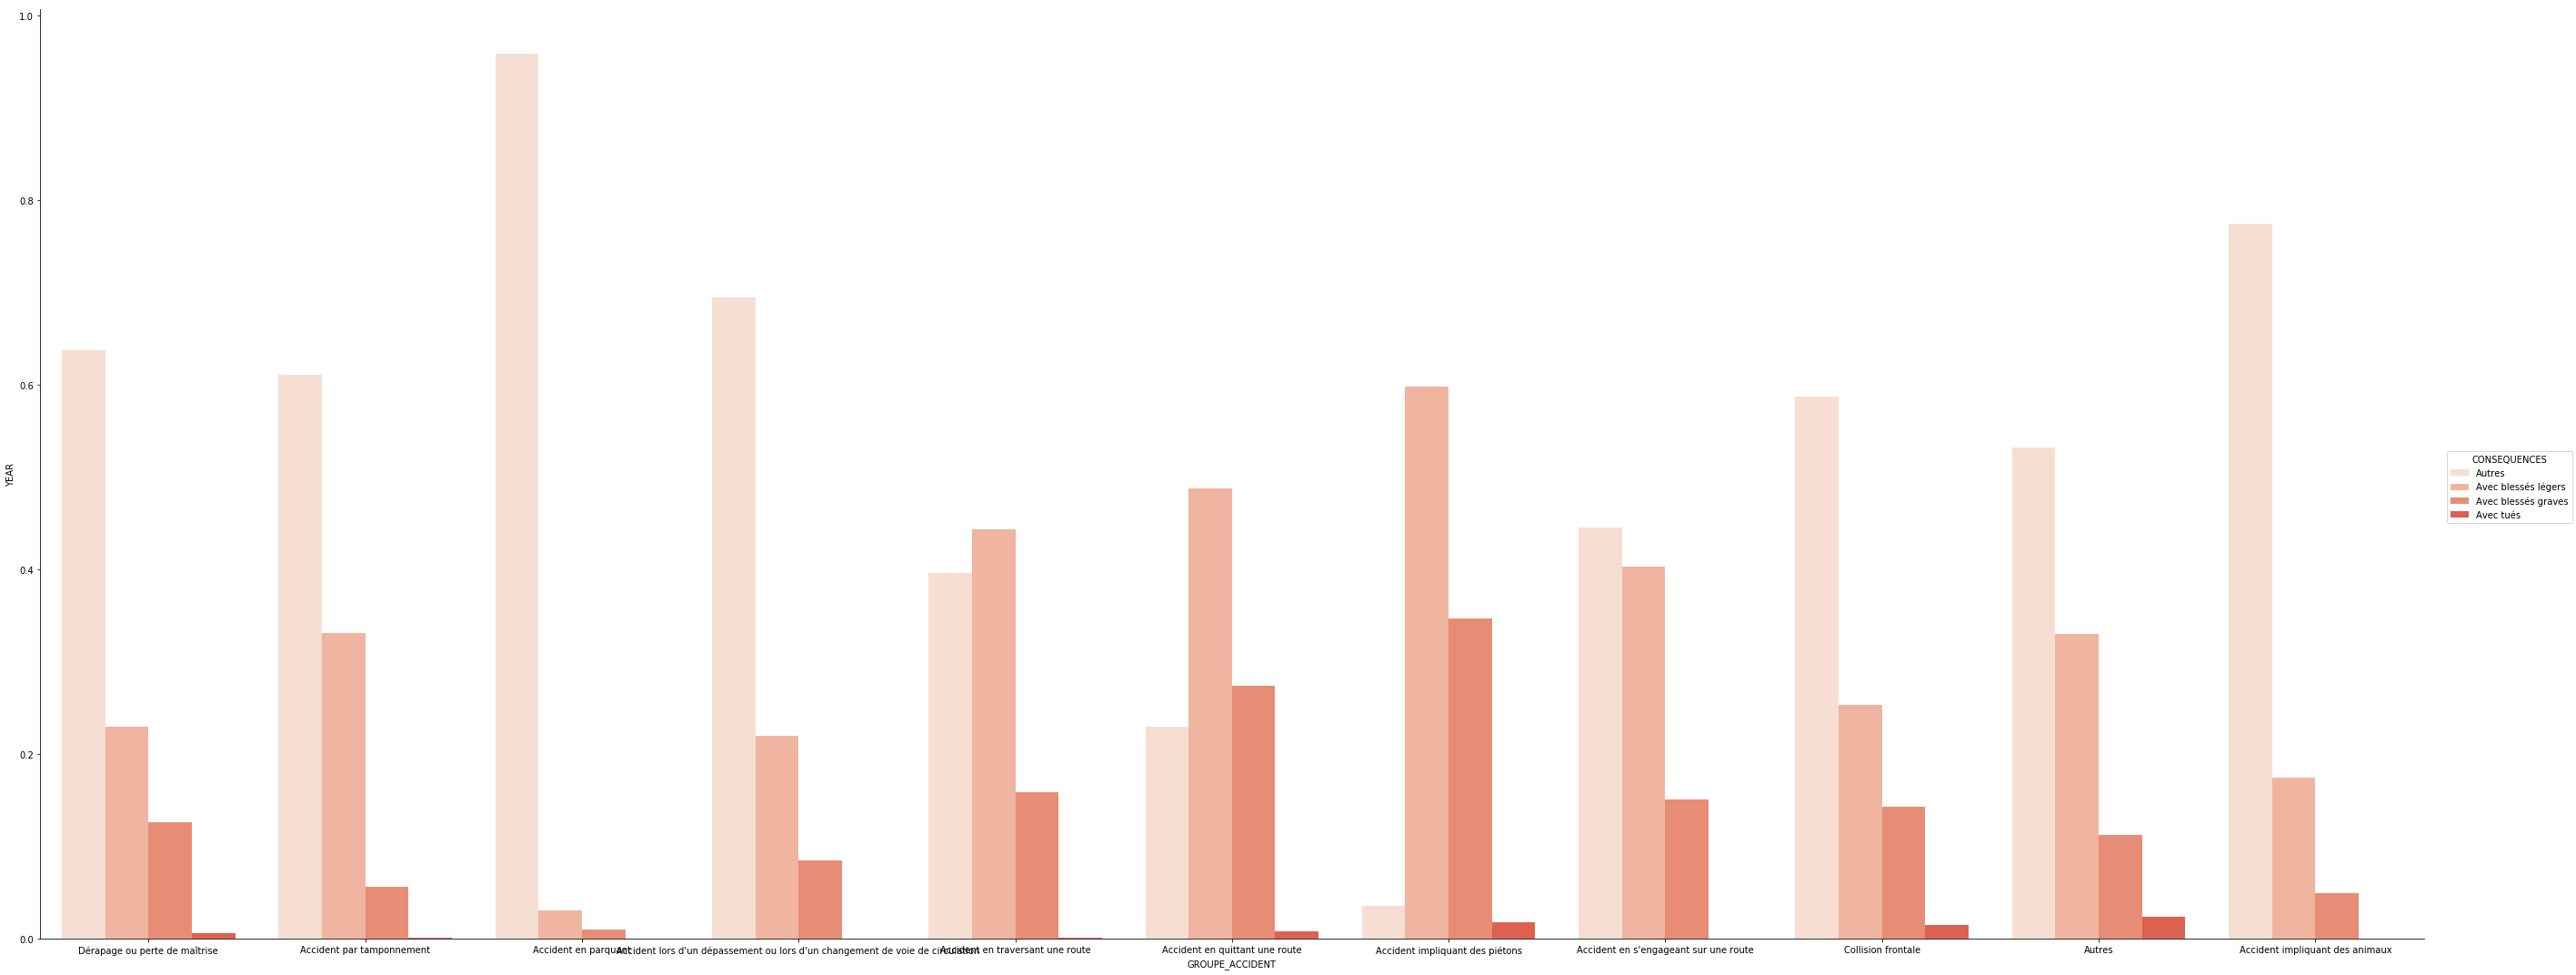

In [46]:
# Visualize it 
order_groupacc = acc_df.GROUPE_ACCIDENT.value_counts().index
palette = sns.set_palette("Reds")
ax = sns.factorplot(data=consequences_pvt, x="GROUPE_ACCIDENT", y="YEAR",   
                    hue="CONSEQUENCES", 
                    hue_order=['Autres', 'Avec blessés légers', 'Avec blessés graves', 'Avec tués'],
                    order=order_groupacc,
                    legend_out=True, orient='v',
                    size=15, aspect=2.5, kind="bar", palette=palette)

xticks_accident_group()
ax.set_yticklabels(fontsize=30)
ax.set_xticklabels(fontsize=30, rotation=90)
ax.set_axis_labels("Accident group","% Light condition ratio")
plt.title('Consequences per accident group', fontsize=50).set_weight('bold')
plt
plt.legend(loc='upper center', bbox_to_anchor=(1.05,1), fontsize=30)

It can be observed that the feature with higher correlation with the kind of consequence is the number of pedetrian involved.

A further analysis could be done to investigate the correlation between the accident group and the seriouness of the accident.

### 2.5.1 Children accidents

In this sub section, the accidents where the children were involved are investigated. The followig questions will be investigated:
- Where are localisated the children accidents?
- What are the main causes of this accidents?
- Which are the main conditions when the accients happen?

In [230]:
# New dataframe for the children accident
acc_df['ENFANTS_IMPLIQUES'] = np.where(acc_df.NB_ENFANTS_IMPLIQUES > 1, 1, 0)
accident_enfant = acc_df[acc_df.ENFANTS_IMPLIQUES == 1].reset_index().drop('index', axis=1)
accident_enfant.shape

(103, 44)

It can be observed that the number of children involved in a accident (with injured or dead people) is a small proportion of all accidents (103 out of 19000). Let's investigate from this 103 accidents where children where involved, how many children in a school environment were involved:

In [231]:
accident_enfant.NB_ENFANTS_ECOLE.value_counts()

0.0     97
2.0      3
11.0     1
3.0      1
1.0      1
Name: NB_ENFANTS_ECOLE, dtype: int64

We can draw the conclusion that in most of the cases, the children accidents were not provoqued in a school environment.

#### 1.1 Where are the children accidents located?

In [232]:
# Locate children accident in the map
Geneve_coord = [46.2004013, 6.1531163]
m = folium.Map(location=Geneve_coord,
               tiles='OpenStreetMap',
               zoom_start=10)

for i in range(0, len(accident_enfant['COOR_X'])-1):
    folium.Marker([accident_enfant.COOR_Y.loc[i], accident_enfant.COOR_X.loc[i]] , popup="1").add_to(m)
    
m

The goal in this section was to identify if there is a zone with more risk than other. From the plot above, it can be observed that the accidents are quite spread in the geneva region.

#### 1.2 What are the main causes?

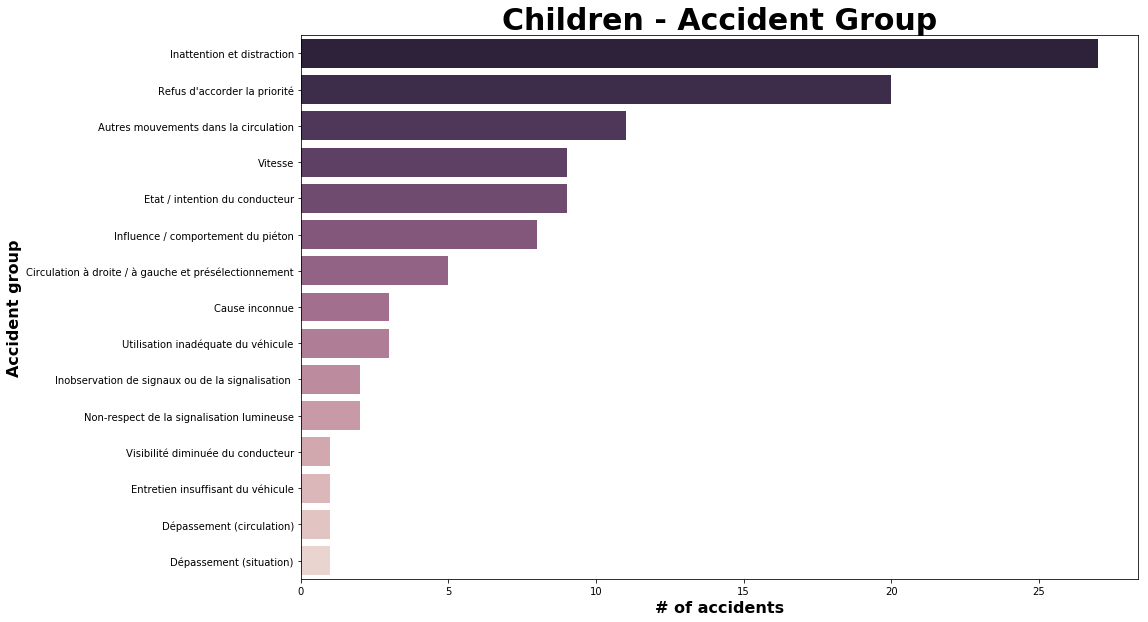

In [233]:
# Visualize main causes
plt.figure(figsize=(15,10))
ax = sns.barplot(x=accident_enfant.CAUSE_g.value_counts(), 
                 y=accident_enfant.CAUSE_g.value_counts().index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(accident_enfant.CAUSE_g.value_counts().index)))
#value_barplot_label(ax)
plt.title("Children - Accident Group", fontsize=30).set_weight('bold')
#tick_format(ax, 1)
ax.set_ylabel('Accident group', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

In [234]:
# Number of death children in accidents
accident_enfant.NB_TUES.value_counts()

0.0    102
1.0      1
Name: NB_TUES, dtype: int64

In [235]:
# Number of death children in accidents
accident_enfant.NB_BLESSES_GRAVES.value_counts()

0.0    81
1.0    20
2.0     1
3.0     1
Name: NB_BLESSES_GRAVES, dtype: int64

In [236]:
# Number of death children in accidents
accident_enfant.NB_BLESSES_LEGERS.value_counts()

0.0    28
1.0    26
2.0    18
3.0    16
4.0     7
5.0     7
6.0     1
Name: NB_BLESSES_LEGERS, dtype: int64

In [237]:
accident_enfant.YEAR.value_counts()

2016    22
2013    21
2015    17
2014    17
2012    10
2011     8
2010     8
Name: YEAR, dtype: int64

From this section, we can draw that the number of accidents where there are children involved have not increased during the years. In addition, the proportion of children deaths is very low. Finally we can observe that when there is a slight accident in children, there are multiple children involved.

A further analysis could be to investigate if this accidents are near the schools.

## 2.6 Vehicles involved

In this section, the type of vehicles will be analysed.

In [238]:
# Create grouped vehicles feature
acc_df['NB_MOTO'] = acc_df['NB_CYCLOMOTEURS'] + acc_df['NB_MOTOS_50'] + acc_df['NB_MOTOS_125']
acc_df['NB_BIKE'] = acc_df['NB_BICYCLETTES'] + acc_df['NB_VAE_25'] + acc_df['NB_VAE_45']
acc_df['NB_TPubl'] = acc_df['NB_BUS']+acc_df['NB_TRAM']
acc_df['NB_ProfT'] = acc_df['NB_VOITURES_LIVRAISON'] + acc_df['NB_CAMIONS']
acc_df['NB_LourdT'] = acc_df['NB_VOITURES_LIVRAISON'] + acc_df['NB_CAMIONS'] + acc_df['NB_BUS']+acc_df['NB_TRAM']

In [72]:
acc_df.head(3)

,DATE_,GROUPE_ACCIDENT,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,GENRE_ROUTE,...,DayTime,SEASON,CAUSE_g,CAUSE_sg,ENFANTS_IMPLIQUES,NB_MOTO,NB_BIKE,NB_TPubl,NB_ProfT,NB_LourdT
0,2010-11-30,Dérapage ou perte de maîtrise,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,Route secondaire,...,Evening,Autumn,Inattention et distraction,Manque d'attention momentané,0,0.0,0.0,0.0,0.0,0.0
1,2010-12-08,Autres,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,Route secondaire,...,Afternoon,Winter,Utilisation inadéquate du véhicule,Stationnement sans précautions suffisantes,0,0.0,0.0,0.0,0.0,0.0
2,2010-12-02,Dérapage ou perte de maîtrise,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,Enneigée,Route secondaire,...,Morning,Winter,Inobservation de signaux ou de la signalisation,Inobservation des règles de la circulation don...,0,0.0,0.0,0.0,0.0,0.0


In [239]:
# Select vehicles features realted
vehicles_features = ['NB_BICYCLETTES','NB_VAE_25', 'NB_VAE_45', 'NB_CYCLOMOTEURS', 'NB_MOTOS_50','NB_MOTOS_125', 
                     'NB_MOTOS_11KW', 'NB_VOITURES_TOURISME','NB_VOITURES_LIVRAISON', 'NB_CAMIONS', 'NB_BUS', 
                     'NB_TRAM', 'NB_MOTO', 'NB_BIKE', 'NB_TPubl', 'NB_ProfT', 'NB_LourdT']
acc_df[vehicles_features].head(3)

,NB_BICYCLETTES,NB_VAE_25,NB_VAE_45,NB_CYCLOMOTEURS,NB_MOTOS_50,NB_MOTOS_125,NB_MOTOS_11KW,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,NB_MOTO,NB_BIKE,NB_TPubl,NB_ProfT,NB_LourdT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


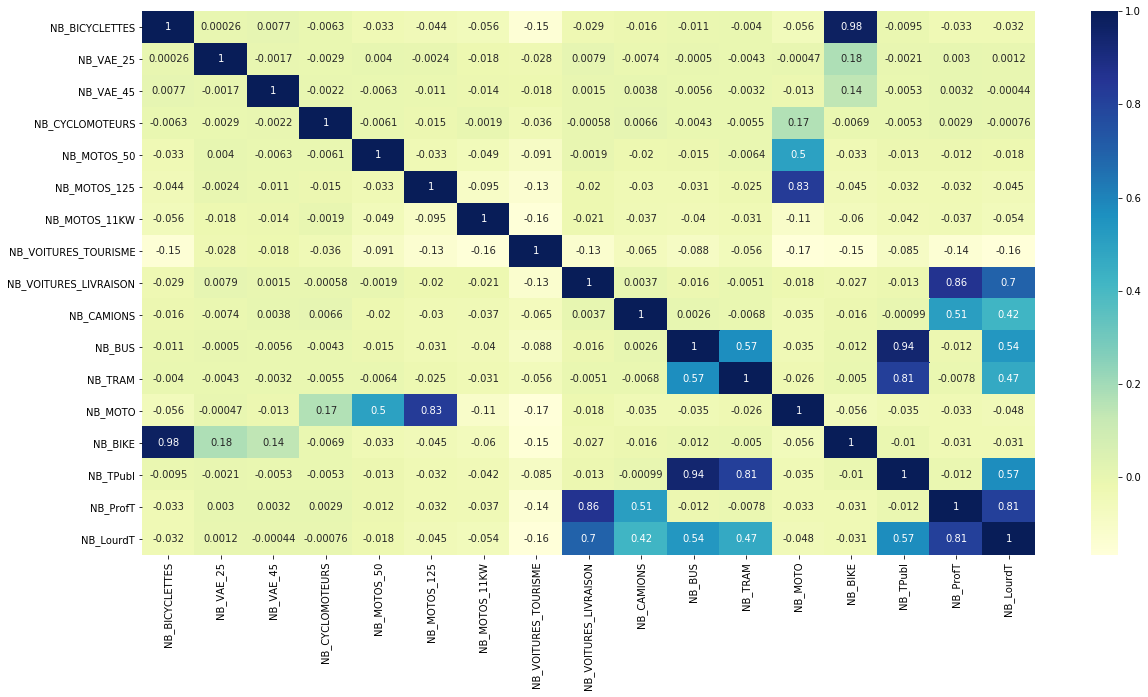

In [74]:
# Check correlations
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(acc_df[vehicles_features].corr(), cmap="YlGnBu", annot=True)

From this correlation matrix, it can be identified that the **tram and bus** accidents are highly correlated. A further analysis can be developed in order to understand this correlation.

In addition, the different vehclicle can be analysed deeply: seeing correlation on the conditions for example.

In [263]:
acc_df.columns

Index(['DATE_', 'GROUPE_ACCIDENT', 'COMMUNE', 'CONDITIONS_LUMINEUSES',
       'CONDITIONS_METEO', 'CONSEQUENCES', 'COOR_X', 'COOR_Y', 'ETAT_ROUTE',
       'GENRE_ROUTE', 'JOUR', 'LOCALITE', 'NB_ENFANTS_IMPLIQUES',
       'NB_ENFANTS_ECOLE', 'NB_BLESSES_LEGERS', 'NB_BLESSES_GRAVES', 'NB_TUES',
       'NB_PIETONS', 'NB_BICYCLETTES', 'NB_VAE_25', 'NB_VAE_45',
       'NB_CYCLOMOTEURS', 'NB_MOTOS_50', 'NB_MOTOS_125', 'NB_MOTOS_11KW',
       'NB_VOITURES_TOURISME', 'NB_VOITURES_LIVRAISON', 'NB_CAMIONS', 'NB_BUS',
       'NB_TRAM', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'DayTime', 'SEASON',
       'NB_MOTO', 'NB_BIKE', 'NB_TPubl', 'NB_ProfT', 'NB_LourdT', 'CAUSE_g',
       'CAUSE_sg', 'ENFANTS_IMPLIQUES'],
      dtype='object')

In [243]:
acc_df = acc_df[acc_df['NB_MOTO']>0]

pd.crosstab(acc_motos.YEAR, acc_motos.CONSEQUENCES, margins=False).style.background_gradient(cmap='summer_r')

CONSEQUENCES,Autres,Avec blessés graves,Avec blessés légers,Avec tués
YEAR,,,,
2010,70,117,181,3
2011,45,94,194,4
2012,52,111,214,1
2013,60,109,216,3
2014,50,102,198,2
2015,34,43,120,1
2016,45,53,129,0


In [256]:
pd.crosstab(acc_motos.CONSEQUENCES, acc_motos.CONDITIONS_LUMINEUSES, margins=False).style.background_gradient(cmap='summer_r')

CONDITIONS_LUMINEUSES,Aurore / crépuscule,Inconnu,Jour,Nuit
CONSEQUENCES,,,,
Autres,16,2,244,94
Avec blessés graves,32,0,428,169
Avec blessés légers,67,0,930,255
Avec tués,3,0,7,4


In [ ]:

sns.heatmap(flights)

## Save the dataframe with new features

In order to summerize all the new features added in this Exploratory analysis, we save this dataframe in our main directory. This dataframe will be used in further analysis.

In [76]:
# Upload
acc_df.to_pickle('acc_df.pkl')
acc_df1 = acc_df.copy()
acc_df1.to_csv('acc_df1.csv', encoding='utf-8')